# Time Series Models - Arima & Prophet

### 1. Importing / Installing packages

In [28]:
import os
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import itertools

%matplotlib inline

# - pip install numpy
# - pip install scipy 
# - pip install sciki-learn

# To change scientific numbers to float when using numpy
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

# Increases the size of sns plots
sns.set(rc={'figure.figsize':(8,6)})


# installing auto arima
# pip install --user pmdarima

# import ARIMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import pmdarima as pm
from pmdarima.model_selection import train_test_split


# installing fbprophet
# pip install fbprophet
# !pip install --upgrade plotly

#import PROPHET
from fbprophet import Prophet

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

from pandas import to_datetime

import itertools
import warnings

import datetime
from datetime import datetime
warnings.filterwarnings('ignore')

### 2. Problem Formulation - What are we trying to solve?

We want to forecast the average temperature per month in Benin per district for the next 12 months (1 year). To achieve this goal we'll use the world monthly temparature dataset and time series models such as Ariama and facebook Prophet

### 3 Reading / Loading the Raw Data into Python From CSV

In [29]:
#Transform the data set

df = pd.read_csv('tmax_2000_2018.csv')

df1 = (df.set_index(["Adresse", "Arrondissement","Pays","Latitude","Longitude"])
         .stack()
         .reset_index(name='Value')
         .rename(columns={'level_5':'Date'}))

df1.to_csv('tmp_max_2000_2018.csv')

# Loading the data
raw_data = pd.read_csv('./tmp_max_2000_2018.csv', encoding='utf-8')

# print the shape
print(raw_data.shape)

#runs the first 5 rows
raw_data

(120384, 8)


,Unnamed: 0,Adresse,Arrondissement,Pays,Latitude,Longitude,Date,Value
0,0,"Banikoara,Bénin",Banikoara,Bénin,11.293453,2.435696,2018-12,33.43966
1,1,"Banikoara,Bénin",Banikoara,Bénin,11.293453,2.435696,2018-11,36.31371
2,2,"Banikoara,Bénin",Banikoara,Bénin,11.293453,2.435696,2018-10,32.85116
3,3,"Banikoara,Bénin",Banikoara,Bénin,11.293453,2.435696,2018-09,30.66303
4,4,"Banikoara,Bénin",Banikoara,Bénin,11.293453,2.435696,2018-08,29.71329
...,...,...,...,...,...,...,...,...
120379,120379,"Zoukou,Bénin",Zoukou,Bénin,7.044773,2.184328,2000-05,33.16874
120380,120380,"Zoukou,Bénin",Zoukou,Bénin,7.044773,2.184328,2000-04,34.19402
120381,120381,"Zoukou,Bénin",Zoukou,Bénin,7.044773,2.184328,2000-03,35.46366
120382,120382,"Zoukou,Bénin",Zoukou,Bénin,7.044773,2.184328,2000-02,34.99636


In [30]:
df = pd.read_csv('final_min_temp_prophet.csv')
df['Date'] = pd.to_datetime(df['Date'])
df2019 = df[df['Date'] >= '2019-01-01']
df2019.to_csv('future_min_temp.csv')

### 4. Data Pre-Processing Phase

In [31]:
# Checking for null values
raw_data.isnull().sum()

Unnamed: 0        0
Adresse           0
Arrondissement    0
Pays              0
Latitude          0
Longitude         0
Date              0
Value             0
dtype: int64

In [32]:
# filtering out the dataFrame to have only neccessary columns
raw_data = raw_data[['Value','Adresse','Date']]
raw_data.columns = ['temp_max','district','date']
# Checking for null values
raw_data.isnull().sum()
#raw_data

temp_max    0
district    0
date        0
dtype: int64

In [33]:
# change the raw_data variable name

forecast_data = raw_data
forecast_data.head()

,temp_max,district,date
0,33.43966,"Banikoara,Bénin",2018-12
1,36.31371,"Banikoara,Bénin",2018-11
2,32.85116,"Banikoara,Bénin",2018-10
3,30.66303,"Banikoara,Bénin",2018-09
4,29.71329,"Banikoara,Bénin",2018-08


In [34]:
# Changing the time to date - Most Time Series Models require date structure

forecast_data['date'] = pd.to_datetime(forecast_data['date'])
forecast_data.head()

,temp_max,district,date
0,33.43966,"Banikoara,Bénin",2018-12-01
1,36.31371,"Banikoara,Bénin",2018-11-01
2,32.85116,"Banikoara,Bénin",2018-10-01
3,30.66303,"Banikoara,Bénin",2018-09-01
4,29.71329,"Banikoara,Bénin",2018-08-01


### 5. Spliting the Raw Data (train and test set)

In [51]:
valid_data = forecast_data

# X_train is the training set. 
X_train = valid_data[valid_data['date'] <= '2015-12-01']

# x_valid is the test set
X_valid = forecast_data[forecast_data['date'] >= '2015-01-01']

#print('X_train Shape', X_train.shape)
#print('X_Valid Shape', X_valid.shape)
#X_valid['date'].unique()
#X_train['dt'].unique()
X_valid

,temp_max,district,date
0,33.43966,"Banikoara,Bénin",2018-12-01
1,36.31371,"Banikoara,Bénin",2018-11-01
2,32.85116,"Banikoara,Bénin",2018-10-01
3,30.66303,"Banikoara,Bénin",2018-09-01
4,29.71329,"Banikoara,Bénin",2018-08-01
...,...,...,...
120199,33.98593,"Zoukou,Bénin",2015-05-01
120200,34.63465,"Zoukou,Bénin",2015-04-01
120201,35.11366,"Zoukou,Bénin",2015-03-01
120202,36.16824,"Zoukou,Bénin",2015-02-01


### 6. Running Arima (Autoregressive Integrated Moving Average)  for Banikoara District

ARIMA:
- Uses a number of lagged observations of time series to forecast observations

Inputs / Parameters:
- p: the number of lag observations in the model; also known as the lag order (AR)
- d: the number of times that the raw observations are differenced; also known as the degree of differencing (I)
- q: the size of the moving average window; also known as the order of the moving average (MA)

https://www.investopedia.com/terms/a/autoregressive-integrated-moving-average-arima.asp

In [52]:

# filtering the train data to keep only benin data
d = "Banikoara,Bénin"
bj = X_train[X_train['district'] == d]
bj.head()
#drop out the district column - we don't need it anymore
bj = bj[['date', 'temp_max']]

#filtering the test data
bj_v = X_valid[X_valid['district'] == d]
bj_v = bj_v[['date', 'temp_max']]

# set the date into index
bj.set_index('date', inplace=True)
bj_v.set_index('date', inplace=True)

# same process to all valid data
valid_data = valid_data[valid_data['district'] == d]
valid_data = valid_data[['date', 'temp_max']]
valid_data.set_index('date', inplace=True)

# Setting the Index for the test set 12 months
index_12_months = pd.date_range(bj_v.index[-1], freq='MS', periods = 48) 

index_12_months

DatetimeIndex(['2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01',
               '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
               '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01',
               '2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01',
               '2016-05-01', '2016-06-01', '2016-07-01', '2016-08-01',
               '2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01',
               '2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01',
               '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01',
               '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01',
               '2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01',
               '2018-05-01', '2018-06-01', '2018-07-01', '2018-08-01',
               '2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01'],
              dtype='datetime64[ns]', freq='MS')

The MSE of ARIMA is: 1.9642776153339916


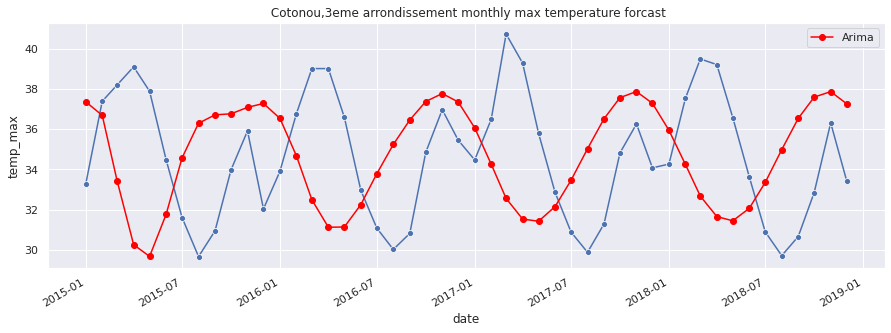

In [53]:
# Running ARIMA with random numbers
#model_arima = ARIMA(bj, order=(2,0,2)) # start 2-0-2 and move to the best -> MSE 2.5648817219657984

# after searching for the best parameters (next section) -> MSE 0.7611247283774982
model_arima = ARIMA(bj, order=(4, 0, 3))

model_arima_fit = model_arima.fit(disp=-1)

# Saving ARIMA predictions
fcast1 = model_arima_fit.forecast(48)[0]

# Passing the same index as the others
fcast1 = pd.Series(fcast1, index=index_12_months)
fcast1 = fcast1.rename("Arima")

# Ploting the predictions
fig, ax = plt.subplots(figsize=(15,5))
chart = sns.lineplot(x='date', y='temp_max', data = bj_v, marker="o")
chart.set_title(' Cotonou,3eme arrondissement monthly max temperature forcast')
fcast1.plot(ax=ax, color='red', marker="o", legend=True)
#bj_v.plot(ax=ax, color='blue', marker="o", legend=True)

# Printing the AI
print('The MSE of ARIMA is:', mean_squared_error(bj_v['temp_max'].values, fcast1.values, squared=False))

In [45]:
residu = bj_v['temp_max'] - fcast1
mse = round(np.mean(abs(residu / bj_v['temp_max'])),4)
mse

0.1159

Text(0.5, 1.0, 'Résidu ARIMA model Banikoara')

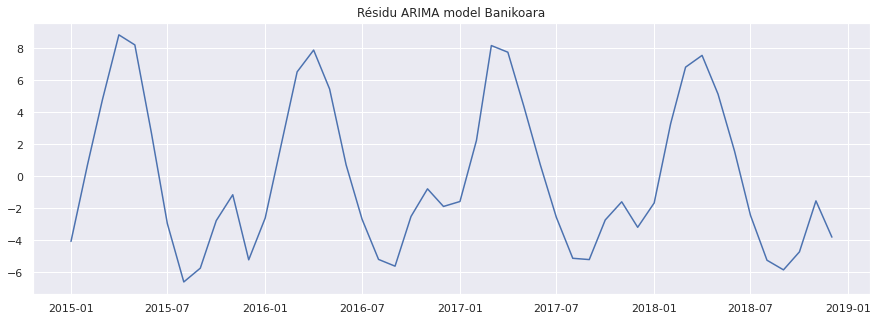

In [47]:
fig, ax = plt.subplots(figsize=(15,5))
chart = sns.lineplot( data = residu)
chart.set_title('Résidu ARIMA model Banikoara')

In [28]:
model_arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               temp_min   No. Observations:                  192
Model:                     ARMA(2, 3)   Log Likelihood                -176.939
Method:                       css-mle   S.D. of innovations              0.595
Date:                Wed, 15 Dec 2021   AIC                            367.878
Time:                        11:20:06   BIC                            390.681
Sample:                             0   HQIC                           377.114
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             24.3381      0.056    433.913      0.000      24.228      24.448
ar.L1.temp_min     1.7321      0.002    899.146      0.000       1.728       1.736
ar.L2.temp_min    -1.0000      0.001  -1740.512      0.000      -1.001      -0.999
ma.L1.temp_min    -1.4080      0.076    -18.582      0.000      -1.557      -1.259
ma.L2.temp_min     0.4317      0.136      3.174      0.002       0.165       0.698
ma.L3.temp_min     0.3266      0.076      4.290      0.000       0.177       0.476
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.8661           -0.4999j            1.0000           -0.0833
AR.2            0.8661           +0.4999j            1.0000            0.0833
MA.1            0.8684           -0.4969j            1.0005           -0.0827
MA.2            0.8684           +0.4969j            1.0005            0.0827
MA.3           -3.0586           -0.0000j            3.0586           -0.5000
-----------------------------------------------------------------------------
"""

In [41]:
p=d=q=range(0,5)
pdq = list(itertools.product(p,d,q))

In [42]:
# Option 1 : Finding the best value for ARIMA
import itertools
p=d=q=range(0,5)
pdq = list(itertools.product(p,d,q))

values = []
params = []
for param in pdq:
    try:
        model_arima = ARIMA(bj,order=param)
        model_arima_fit = model_arima.fit()
        print(param,model_arima_fit.aic)
        values.append(model_arima_fit.aic)
        params.append(param)
    except:
        continue

index =values.index(min(values))
print(index)
print(params[index])

(0, 0, 0) 969.0110101486644
(0, 0, 1) 830.3383303475396
(0, 0, 2) 763.6014919662532
(0, 0, 3) 757.578999590788
(0, 0, 4) 759.4490203842092
(0, 1, 0) 866.1546374855602
(0, 1, 1) 824.9681413006545
(0, 1, 2) 822.0778883085013
(0, 1, 3) 765.7178209919566
(0, 1, 4) 759.272017326163
(0, 2, 0) 901.4953453762632
(0, 2, 1) 903.3312200397899
(0, 2, 2) 828.1571512068224
(0, 2, 3) 824.7793851824626
(0, 2, 4) 776.0979640724365
(1, 0, 0) 841.7191475095628
(1, 0, 1) 785.263061993579
(1, 0, 2) 817.289219703503
(1, 0, 3) 741.2056119822344
(1, 0, 4) 724.0880890714371
(1, 1, 0) 838.3568886936571
(1, 1, 4) 761.2473927646081
(1, 2, 0) 903.4393058704138
(2, 0, 0) 751.5357018251698
(2, 0, 1) 725.5090151092367
(2, 0, 2) 708.81674300388
(2, 0, 3) 708.2819721716504
(2, 1, 0) 805.012850373993
(2, 1, 2) 755.9296695353946
(2, 1, 3) 756.8054695844211
(2, 1, 4) 773.3520730899941
(2, 2, 0) 887.2168431703356
(3, 0, 0) 753.3943113413972
(3, 0, 2) 758.73365362219
(3, 0, 3) 734.9584198159561
(3, 0, 4) 752.3174298257733
(

In [14]:
#display forcast value
fcast1

2015-01-01    24.513499
2015-02-01    23.996222
2015-03-01    23.591996
2015-04-01    23.387615
2015-05-01    23.437811
2015-06-01    23.729129
2015-07-01    24.183539
2015-08-01    24.679332
2015-09-01    25.083720
2015-10-01    25.288401
2015-11-01    25.238564
2015-12-01    24.947566
2016-01-01    24.493353
2016-02-01    23.997580
2016-03-01    23.593031
2016-04-01    23.388049
2016-05-01    23.437528
2016-06-01    23.728205
2016-07-01    24.182222
2016-08-01    24.677974
2016-09-01    25.082685
2016-10-01    25.287967
2016-11-01    25.238847
2016-12-01    24.948490
2017-01-01    24.494670
2017-02-01    23.998939
2017-03-01    23.594066
2017-04-01    23.388485
2017-05-01    23.437247
2017-06-01    23.727283
2017-07-01    24.180905
2017-08-01    24.676615
2017-09-01    25.081649
2017-10-01    25.287530
2017-11-01    25.239127
2017-12-01    24.949411
2018-01-01    24.495987
2018-02-01    24.000297
2018-03-01    23.595103
2018-04-01    23.388922
2018-05-01    23.436967
2018-06-01    23

In [13]:
#display real value
bj_v

,temp_min
date,
2018-12-01,24.38027
2018-11-01,24.99258
2018-10-01,24.25412
2018-09-01,23.71024
2018-08-01,23.54535
2018-07-01,23.82848
2018-06-01,24.12556
2018-05-01,24.94397
2018-04-01,25.29154


The RMSE of auto-arima is: 3.0303067386824822


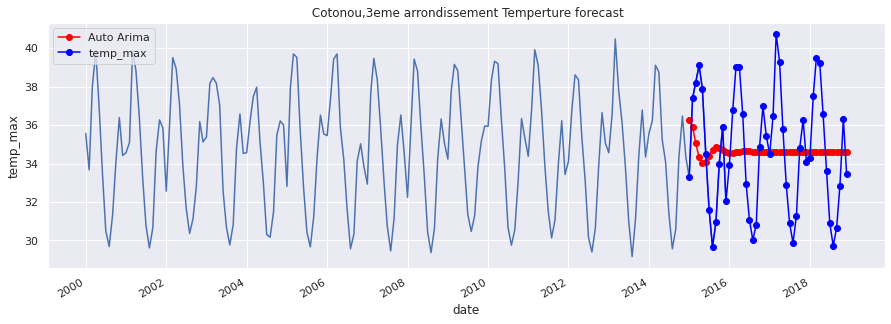

In [56]:
# Option 2 : Auto ARIMA

# Running auto ARIMA 
auto_arima_model = pm.auto_arima(bj, seasonal=False, m=12)

# make the forecasts
fcast2 = auto_arima_model.predict(48) 
fcast2 = pd.Series(fcast2, index=index_12_months)
fcast2 = fcast2.rename("Auto Arima")

# Ploting the predictions
fig, ax = plt.subplots(figsize=(15,5))
chart = sns.lineplot(x='date', y='temp_max', data = bj)
chart.set_title(' Cotonou,3eme arrondissement Temperture forecast')
fcast2.plot(ax=ax, color='red', marker="o", legend=True)
bj_v.plot(ax=ax, color='blue', marker="o", legend=True)

# Printing the AI
print('The RMSE of auto-arima is:', mean_squared_error(bj_v['temp_max'].values, fcast2.values, squared=False))

### Conclusion

The auto arima doesn't provide accuracy forecast. So we'll retain the first option

### 7. Running Prophet

- Prophet is open source software released by Facebook’s Core Data Science team

- Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality

- It works best with time series that have strong seasonal effects and several seasons of historical data. 

- Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

https://facebook.github.io/prophet/

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The MSE of prophet is: 4.930614245588602


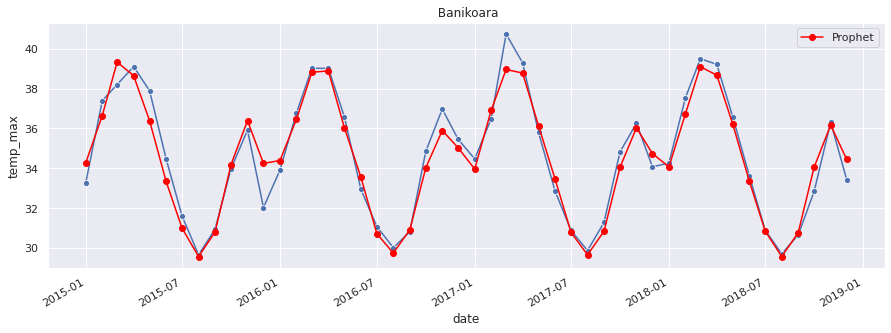

In [57]:
# prepare expected column names
bj2 = X_train[X_train['district'] == d]
bj2 = bj2[['date', 'temp_max']]
bj2.columns = ['ds', 'y'] #prophet model accept only theses parameters
bj2['ds']= to_datetime(bj2['ds'])

# define the model
model = Prophet()
# fit the model
model.fit(bj2)

# define the period for which we want a prediction
df_index_12_months = pd.DataFrame(index_12_months)
df_index_12_months.columns = ['ds']
df_index_12_months['ds']= to_datetime(df_index_12_months['ds'])

# use the model to make a forecast
fcast3 = model.predict(df_index_12_months)
fcast3 = pd.Series(fcast3['yhat'].values, index=index_12_months)
fcast3 = fcast3.rename("Prophet")

# Ploting the predictions
fig, ax = plt.subplots(figsize=(15,5))
chart = sns.lineplot(x='date', y='temp_max', data = bj_v, marker="o")
chart.set_title(' Banikoara')
fcast3.plot(ax=ax, color='red', marker="o", legend=True,)
#bj_v.plot(ax=ax, color='blue', marker="o", legend=True)

# Printing the AI
print('The MSE of prophet is:', mean_squared_error(bj_v['temp_max'].values, fcast3.values, squared=False))

In [59]:
residu = bj_v['temp_max'] - fcast3
mse = round(np.mean(abs(residu / bj_v['temp_max'])),4)
mse

0.0159

In [60]:
residu = bj_v['temp_max'] - fcast3
rmse = np.sqrt(np.mean(residu**2))
rmse

0.7214797677489129

Text(0.5, 1.0, 'Résidu Prophet model 3eme arrondissement cotonou')

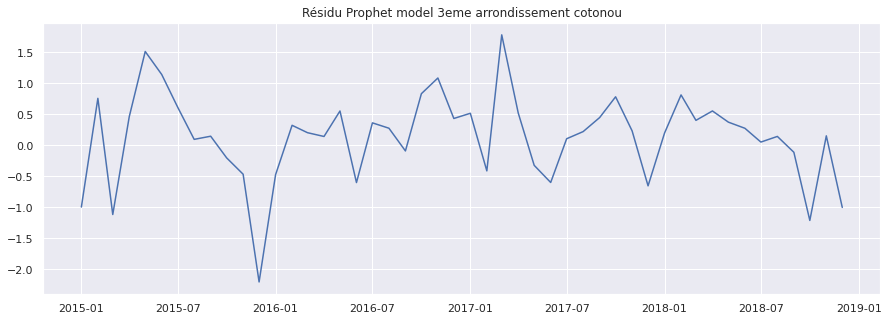

In [61]:
fig, ax = plt.subplots(figsize=(15,5))
chart = sns.lineplot( data = residu)
chart.set_title('Résidu Prophet model 3eme arrondissement cotonou')

In [18]:
model.predict(df_index_12_months)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01,24.436824,23.595476,24.579233,24.436824,24.436824,-0.334093,-0.334093,-0.334093,-0.334093,-0.334093,-0.334093,0.0,0.0,0.0,24.102732
1,2015-02-01,24.443500,25.068854,26.062258,24.443500,24.443500,1.120698,1.120698,1.120698,1.120698,1.120698,1.120698,0.0,0.0,0.0,25.564199
2,2015-03-01,24.449530,25.725830,26.680234,24.449530,24.449530,1.749003,1.749003,1.749003,1.749003,1.749003,1.749003,0.0,0.0,0.0,26.198534
3,2015-04-01,24.456206,24.787920,25.794303,24.456206,24.456206,0.810692,0.810692,0.810692,0.810692,0.810692,0.810692,0.0,0.0,0.0,25.266899
4,2015-05-01,24.462667,24.571196,25.517665,24.462667,24.462667,0.586575,0.586575,0.586575,0.586575,0.586575,0.586575,0.0,0.0,0.0,25.049242
5,2015-06-01,24.469343,23.680778,24.624289,24.469343,24.469343,-0.335603,-0.335603,-0.335603,-0.335603,-0.335603,-0.335603,0.0,0.0,0.0,24.133740
6,2015-07-01,24.475804,23.264107,24.254818,24.475804,24.475804,-0.722201,-0.722201,-0.722201,-0.722201,-0.722201,-0.722201,0.0,0.0,0.0,23.753603
7,2015-08-01,24.482480,22.731692,23.736036,24.482480,24.482480,-1.284937,-1.284937,-1.284937,-1.284937,-1.284937,-1.284937,0.0,0.0,0.0,23.197542
8,2015-09-01,24.489156,23.205582,24.160633,24.489156,24.489156,-0.825526,-0.825526,-0.825526,-0.825526,-0.825526,-0.825526,0.0,0.0,0.0,23.663630
9,2015-10-01,24.495616,23.820286,24.853206,24.495616,24.495616,-0.169813,-0.169813,-0.169813,-0.169813,-0.169813,-0.169813,0.0,0.0,0.0,24.325803


In [19]:
# predicted value with prophet
fcast3.head()

2015-01-01    24.102732
2015-02-01    25.564199
2015-03-01    26.198534
2015-04-01    25.266899
2015-05-01    25.049242
Freq: MS, Name: Prophet, dtype: float64

In [18]:
# real values
bj_v = bj_v.reindex(index=bj_v.index[::-1])
bj_v

,temp_min
date,
2015-01-01,23.28406
2015-02-01,25.85696
2015-03-01,25.56756
2015-04-01,25.45821
2015-05-01,25.54310
2015-06-01,24.48806
2015-07-01,23.94758
2015-08-01,23.47695
2015-09-01,23.60695


In [35]:
fcast3

2015-01-01    24.102732
2015-02-01    25.564199
2015-03-01    26.198534
2015-04-01    25.266899
2015-05-01    25.049242
2015-06-01    24.133740
2015-07-01    23.753603
2015-08-01    23.197542
2015-09-01    23.663630
2015-10-01    24.325803
2015-11-01    24.905316
2015-12-01    24.396106
2016-01-01    24.211263
2016-02-01    25.534650
2016-03-01    25.967765
2016-04-01    25.401710
2016-05-01    24.948852
2016-06-01    24.209664
2016-07-01    24.025987
2016-08-01    23.431314
2016-09-01    23.719945
2016-10-01    24.057993
2016-11-01    24.959871
2016-12-01    24.733741
2017-01-01    24.201130
2017-02-01    25.940761
2017-03-01    26.148625
2017-04-01    25.461985
2017-05-01    25.087897
2017-06-01    24.291212
2017-07-01    24.040717
2017-08-01    23.456352
2017-09-01    23.803204
2017-10-01    24.252313
2017-11-01    25.049725
2017-12-01    24.726656
2018-01-01    24.309116
2018-02-01    25.909356
2018-03-01    26.330459
2018-04-01    25.521933
2018-05-01    25.226259
2018-06-01    24

### 8. Running all Time Series Models Together

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

Gounarou,Bénin Arima Future Error


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Ouara,Bénin Arima Future Error


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Sori,Bénin Arima Train Error


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


NameError: name 't_fcast1' is not defined

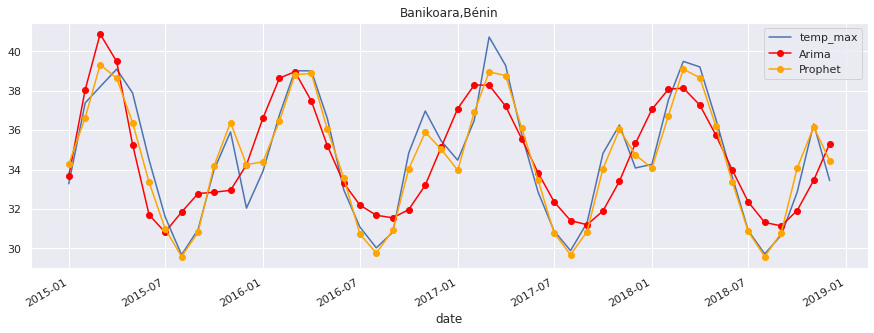

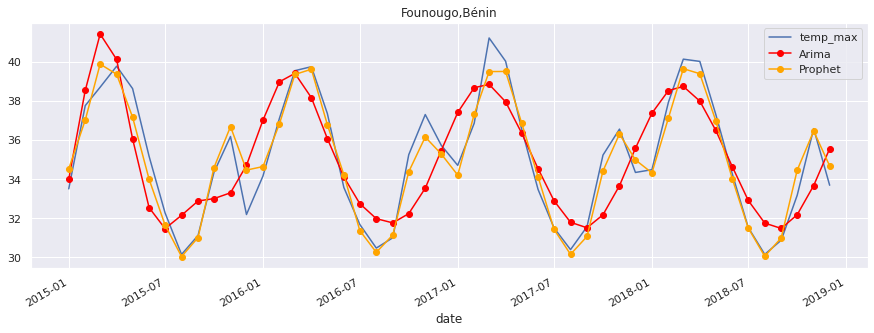

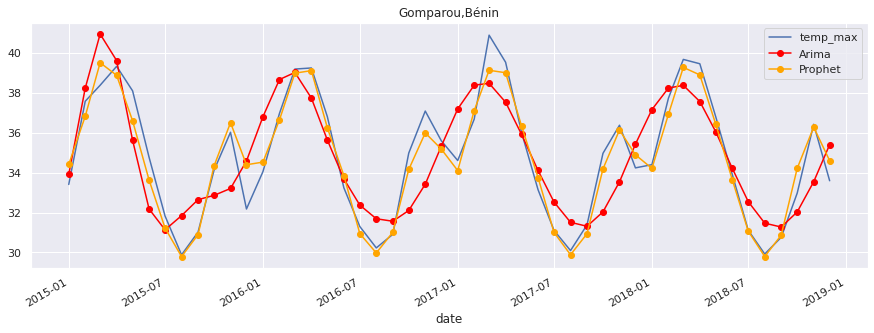

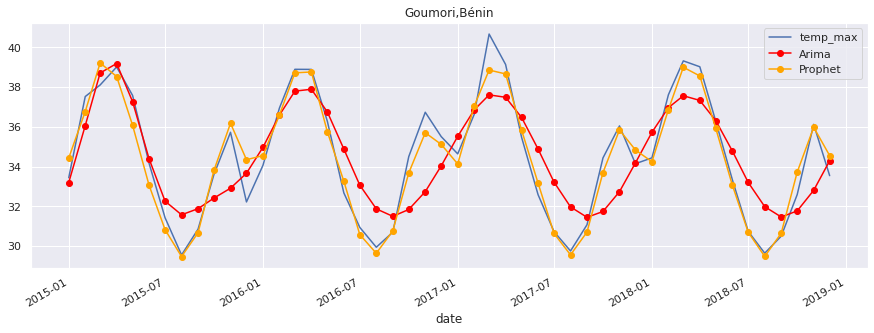

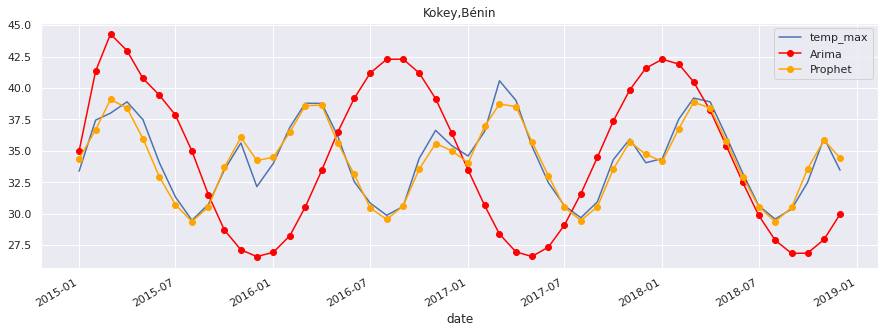

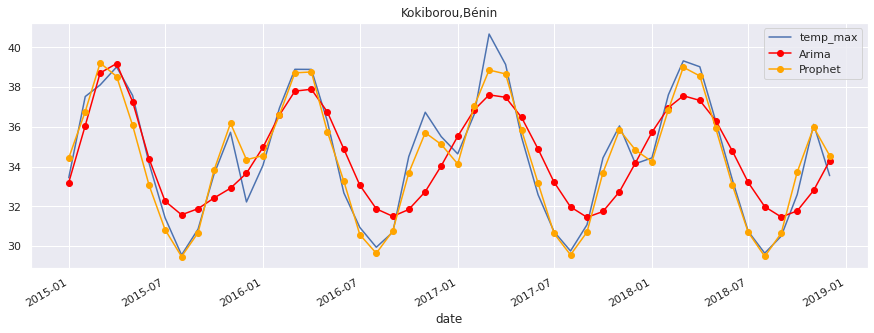

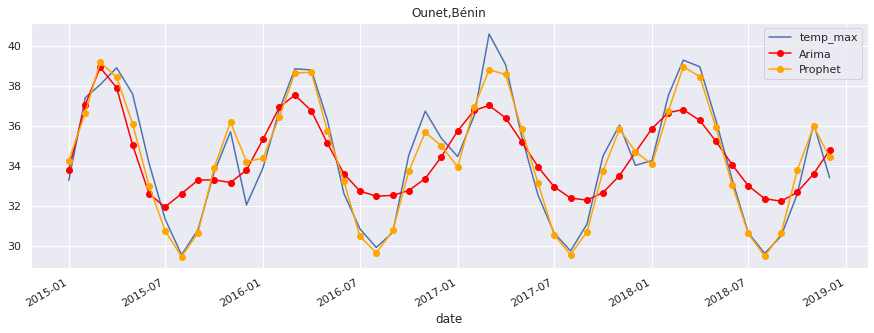

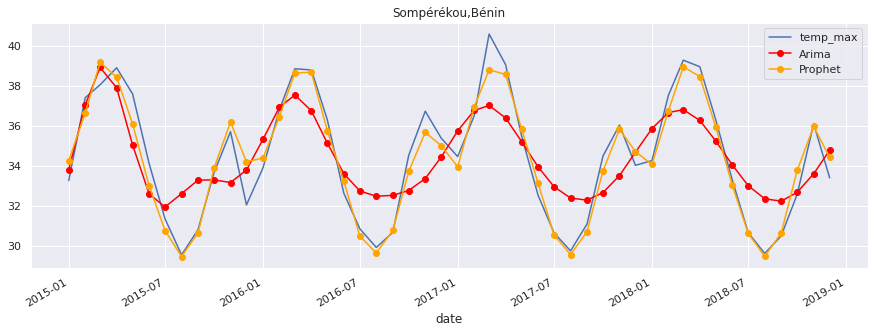

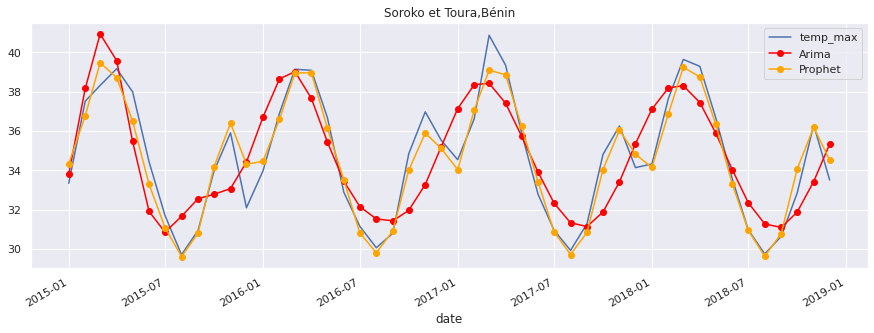

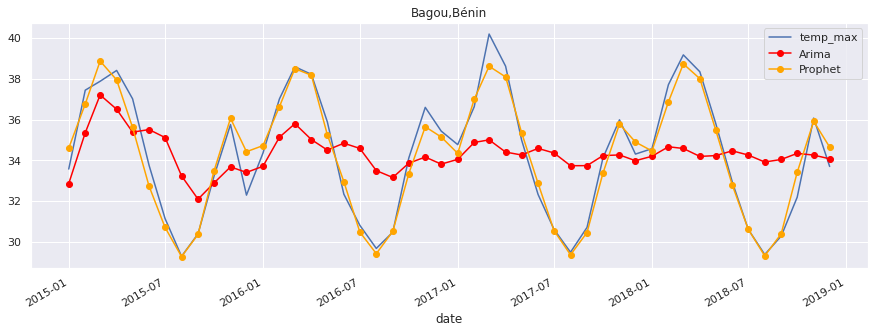

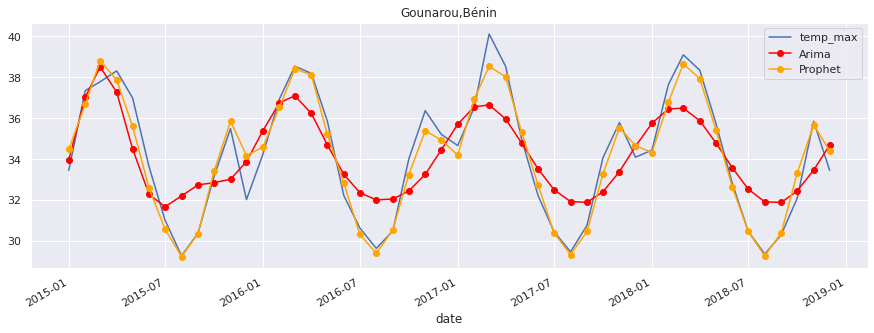

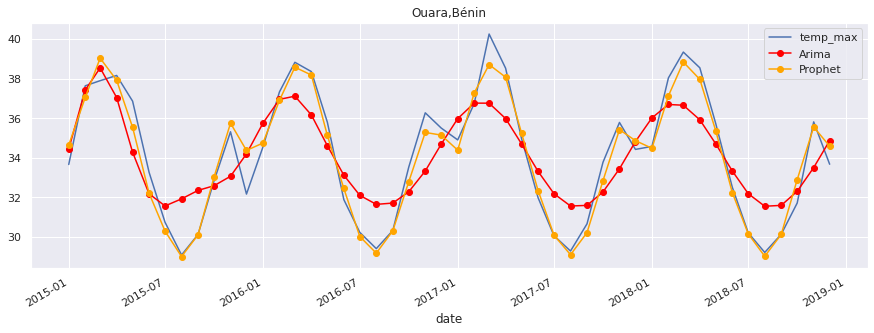

In [62]:
# Step 1 - Arima & Auto-Arima

# creating a district list
districts = forecast_data['district'].unique()
p=d=q=range(0,5)
pdq = list(itertools.product(p,d,q))
#districts = [' Cotonou,3eme arrondissement']
for c in districts:
    # filtering the train data
    train_data = X_train[X_train['district'] == c] # 3 columns
    train_data2 = train_data[['date', 'temp_max']] # 2 columns
    
    # filtering the valid data
    valid_data = X_valid[X_valid['district'] == c]
    valid_data2 = valid_data[['date', 'temp_max']]
    
    
    # all data
    all_data = forecast_data[forecast_data['district']==c]
    all_data2 = all_data[['date', 'temp_max']]
    
    #convert date column to datetime
    train_data2.set_index('date', inplace=True)
    valid_data2.set_index('date', inplace=True)
    valid_data2.columns = ['temp_max']
    all_data2.set_index('date', inplace=True)
    
    # sort date
    train_data2.sort_values(by='date', inplace=True)
    valid_data2.sort_values(by='date', inplace=True)
    all_data2.sort_values(by='date', inplace=True)
    
    
    # Setting the Valid - Index for 12 months
    index_12_months = pd.date_range(valid_data2.index[0], freq='MS', periods = 48)    
    # Setting the Future - Index for 12 months
    
    future_index_12_months = pd.date_range(valid_data2.index[-1], freq='MS', periods = 37) 
    future_index_12_months = future_index_12_months[1:]
    # Dropping all tables
    
    try:
        del t_fcast1
        del t_fcast3
        
        del f_fcast1
        del f_fcast3       
        
    except:
        print("")

    try:
        del df_fcast3
    except:
        print("")
    
    ##############################################################################################################
    ######################################            ARIMA             ##########################################  
    ##############################################################################################################
    
    # THIS IS FOR THE VALIDATION PHASE 

    try:     
        values = []
        params = []
        for param in pdq:
            try:
                model_arima = ARIMA(bj,order=param)
                model_arima_fit = model_arima.fit()
                values.append(model_arima_fit.aic)
                params.append(param)
            except:
                continue

        index =values.index(min(values))
        best = params[index]
        # Running ARIMA on Best parameter
        model_arima = ARIMA(train_data2, order=best)
        model_arima_fit = model_arima.fit(disp=-1)

        # Saving ARIMA predictions
        t_fcast1 = model_arima_fit.forecast(48)[0]
        # Passing the same index as the others
        t_fcast1 = pd.Series(t_fcast1, index=index_12_months)
        t_fcast1 = t_fcast1.rename("Arima") 
    except:
        print(c, "Arima Train Error")
        
    # THIS IS FOR THE FUTURE PHASE
    try:        
        try:
            values = []
            params = []
            for param in pdq:
                try:
                    model_arima = ARIMA(bj,order=param)
                    model_arima_fit = model_arima.fit()
                    values.append(model_arima_fit.aic)
                    params.append(param)
                except:
                    continue
            index =values.index(min(values))
            best = params[index]
            # Running ARIMA on Best parameter
            model_arima = ARIMA(all_data2, best)
            model_arima_fit = model_arima.fit(disp=-1)

            # Saving ARIMA predictions
            f_fcast1 = model_arima_fit.forecast(36)[0]
            # Passing the same index as the others
            f_fcast1 = pd.Series(f_fcast1, index=future_index_12_months)
            f_fcast1 = f_fcast1.rename("Future - Arima") 
        except:
            model_arima = ARIMA(all_data2, (4,0,1))
            model_arima_fit = model_arima.fit(disp=-1)

            # Saving ARIMA predictions
            f_fcast1 = model_arima_fit.forecast(future_index_12_months)[0]
            # Passing the same index as the others
            f_fcast1 = pd.Series(f_fcast1, index=future_index_12_months)
            f_fcast1 = f_fcast1.rename("Future - Arima")
    except:
        print(c, "Arima Future Error")   
        
        
    ##############################################################################################################
    ######################################      PROPHET             ############################################## 
    ##############################################################################################################
    
    # prepare expected column names
    train_data3 = train_data.copy()
    train_data3 = train_data3[['date', 'temp_max']]
    train_data3.columns = ['ds', 'y']
    train_data3['ds']= to_datetime(train_data3['ds'])
    train_data3.sort_values(by='ds', inplace=True)
    
    all_data3 = all_data.copy()
    all_data3 = all_data3[['date', 'temp_max']]
    all_data3.columns = ['ds', 'y']
    all_data3['ds']= to_datetime(all_data3['ds'])
    all_data3.sort_values(by='ds', inplace=True)
    
    # define the period for which we want a prediction - Valid
    v_df_index_12_months = pd.DataFrame(index_12_months)
    v_df_index_12_months.columns = ['ds']
    v_df_index_12_months['ds']= to_datetime(v_df_index_12_months['ds'])

    # define the period for which we want a prediction - Future
    f_df_index_12_months = pd.DataFrame(future_index_12_months)
    f_df_index_12_months.columns = ['ds']
    f_df_index_12_months['ds']= to_datetime(f_df_index_12_months['ds'])
    
    ############### THIS IS FOR THE VALIDATION PHASE  ##################

    # define the model
    model = Prophet()
    # fit the model
    model.fit(train_data3)

    # use the model to make a forecast
    t_fcast3 = model.predict(v_df_index_12_months)
    t_fcast3 = pd.Series(t_fcast3['yhat'].values, index=index_12_months)
    t_fcast3 = t_fcast3.rename("Prophet")
    
    ############### THIS IS FOR THE VALIDATION PHASE  ##################

    # define the model
    model2 = Prophet()
    # fit the model
    model2.fit(all_data3)

    # use the model to make a forecast
    f_fcast3 = model2.predict(f_df_index_12_months)
    f_fcast3 = pd.Series(f_fcast3['yhat'].values, index=future_index_12_months)
    f_fcast3 = f_fcast3.rename("Future - Prophet")  
        
    ##############################################################################################################
    ########################################      SAVING THE Metrics        ##########################################
    ##############################################################################################################
    

    t_fcast1_mse = round(np.mean(abs((valid_data2["temp_max"].values - t_fcast1.values) / valid_data2["temp_max"].values)),4)
    t_fcast3_mse = round(np.mean(abs((valid_data2["temp_max"].values - t_fcast3.values) / valid_data2["temp_max"].values)),4)
    t_fcast1_rmse = np.sqrt(np.mean((valid_data2["temp_max"].values - t_fcast1.values)**2))
    t_fcast3_rmse = np.sqrt(np.mean((valid_data2["temp_max"].values - t_fcast3.values)**2))

    
    
    ##############################################################################################################
    ########################################      PLOTTING              ##########################################
    ##############################################################################################################
    
    fig, ax = plt.subplots(figsize=(15,5))
    chart = sns.lineplot(data = valid_data2)
    chart.set_title(c)
    # ploting validation
    
    try:
        t_fcast1.plot(ax=ax, color='red', marker="o", legend=True)
    except:
        print("")
    
    t_fcast3.plot(ax=ax, color='orange', marker="o", legend=True)
    
    ##############################################################################################################
    ########################################      SAVING THE RESULTS     #########################################
    ##############################################################################################################
    
    try:
        # Creating a DF for fcast1
        t_fcast1 = t_fcast1.reset_index()
        t_fcast1.columns = ['Date','Arima ForecastValue Validation']

        f_fcast1 = f_fcast1.reset_index()
        f_fcast1.columns = ['Date','Arima ForecastValue Future']

        # Creating the extra columns
        t_fcast1['Arima ForecastValue Future'] = np.nan
        f_fcast1['Arima ForecastValue Validation'] = np.nan

        # reordering 1 only
        t_fcast1 = t_fcast1[['Date','Arima ForecastValue Future','Arima ForecastValue Validation']]

        # Joining them together
        df_fcast1 = pd.concat([t_fcast1, f_fcast1], axis=0)
        df_fcast1['District'] = c
        df_fcast1['ML Method'] = 'Arima'
        df_fcast1['Arima MSE'] = t_fcast1_mse
        df_fcast1['Arima RMSE'] = t_fcast1_rmse
    
    except:
        df_fcast1 = pd.DataFrame({'Date': [np.nan], 'Arima ForecastValue Future': [np.nan],'Arima ForecastValue Validation': [np.nan], 'District':[c], 'ML Method':['Arima'],'Arima MSE':[100], 'Arima RMSE':[100]})
        
    try:
        # Creating a DF for fcast3
        t_fcast3 = t_fcast3.reset_index()
        t_fcast3.columns = ['Date','Prophet ForecastValue Validation']

        f_fcast3 = f_fcast3.reset_index()
        f_fcast3.columns = ['Date','Prophet ForecastValue Future']

        # Creating the extra columns
        t_fcast3['Prophet ForecastValue Future'] = np.nan
        f_fcast3['Prophet ForecastValue Validation'] = np.nan

        # reordering 1 only
        t_fcast3 = t_fcast3[['Date','Prophet ForecastValue Future','Prophet ForecastValue Validation']]

        # Joining them together
        df_fcast3 = pd.concat([t_fcast3, f_fcast3], axis=0)
        df_fcast3 = f_fcast3
        df_fcast3['District'] = c
        df_fcast3['ML Method'] = 'Prophet'
        df_fcast3['Prophet MSE'] = t_fcast3_mse
        df_fcast3['Prophet RMSE'] = t_fcast3_rmse
    
    except:
        df_fcast3 = pd.DataFrame({'Date': [np.nan], 'Prophet ForecastValue Future': [np.nan],'Prophet ForecastValue Validation': [np.nan], 'District':[c], 'ML Method':['Prophet'], 'Prophet MSE':[100], 'Prophet RMSE':[100]})
        
    
    # Aggregating the data to avoid duplication
    df_fcast1 = df_fcast1.groupby(['Date', 'District','ML Method'], as_index = False).agg({'Arima ForecastValue Future':'sum','Arima ForecastValue Validation':'sum','Arima MSE':'max','Arima RMSE':'max'})
    df_fcast3 = df_fcast3.groupby(['Date', 'District','ML Method'], as_index = False).agg({'Prophet ForecastValue Future':'sum','Prophet ForecastValue Validation':'sum','Prophet MSE':'max','Prophet RMSE':'max'})

    # joining them all together
    all_forecasts = df_fcast1.merge(df_fcast3[['Date','Prophet ForecastValue Future','Prophet ForecastValue Validation', 'Prophet MSE', 'Prophet RMSE']], how = 'left', on ='Date')
    all_forecasts['District'] = c
    # Saving the predictions in a DF
    try:
        final_forecasts = pd.concat([final_forecasts, all_forecasts], ignore_index = True)
    except:
        final_forecasts = all_forecasts  
    
    

In [63]:
final_forecasts

,Date,District,ML Method,Arima ForecastValue Future,Arima ForecastValue Validation,Arima MSE,Arima RMSE,Prophet ForecastValue Future,Prophet ForecastValue Validation,Prophet MSE,Prophet RMSE
0,2015-01-01,"Banikoara,Bénin",Arima,0.000000,33.672268,0.0458,1.851624,NaN,NaN,NaN,NaN
1,2015-02-01,"Banikoara,Bénin",Arima,0.000000,38.061797,0.0458,1.851624,NaN,NaN,NaN,NaN
2,2015-03-01,"Banikoara,Bénin",Arima,0.000000,40.881328,0.0458,1.851624,NaN,NaN,NaN,NaN
3,2015-04-01,"Banikoara,Bénin",Arima,0.000000,39.487785,0.0458,1.851624,NaN,NaN,NaN,NaN
4,2015-05-01,"Banikoara,Bénin",Arima,0.000000,35.268401,0.0458,1.851624,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
835,2021-08-01,"Bagou,Bénin",Arima,30.764180,0.000000,0.0672,2.650686,29.468010,0.0,0.0144,0.671904
836,2021-09-01,"Bagou,Bénin",Arima,30.807140,0.000000,0.0672,2.650686,30.533550,0.0,0.0144,0.671904
837,2021-10-01,"Bagou,Bénin",Arima,31.725472,0.000000,0.0672,2.650686,33.497094,0.0,0.0144,0.671904
838,2021-11-01,"Bagou,Bénin",Arima,33.330080,0.000000,0.0672,2.650686,35.945637,0.0,0.0144,0.671904


In [64]:
final_forecasts[final_forecasts['Date'] > '2015-12-01']

,Date,District,ML Method,Arima ForecastValue Future,Arima ForecastValue Validation,Arima MSE,Arima RMSE,Prophet ForecastValue Future,Prophet ForecastValue Validation,Prophet MSE,Prophet RMSE
12,2016-01-01,"Banikoara,Bénin",Arima,0.000000,36.613412,0.0458,1.851624,NaN,NaN,NaN,NaN
13,2016-02-01,"Banikoara,Bénin",Arima,0.000000,38.642299,0.0458,1.851624,NaN,NaN,NaN,NaN
14,2016-03-01,"Banikoara,Bénin",Arima,0.000000,38.967493,0.0458,1.851624,NaN,NaN,NaN,NaN
15,2016-04-01,"Banikoara,Bénin",Arima,0.000000,37.476698,0.0458,1.851624,NaN,NaN,NaN,NaN
16,2016-05-01,"Banikoara,Bénin",Arima,0.000000,35.207545,0.0458,1.851624,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
835,2021-08-01,"Bagou,Bénin",Arima,30.764180,0.000000,0.0672,2.650686,29.468010,0.0,0.0144,0.671904
836,2021-09-01,"Bagou,Bénin",Arima,30.807140,0.000000,0.0672,2.650686,30.533550,0.0,0.0144,0.671904
837,2021-10-01,"Bagou,Bénin",Arima,31.725472,0.000000,0.0672,2.650686,33.497094,0.0,0.0144,0.671904
838,2021-11-01,"Bagou,Bénin",Arima,33.330080,0.000000,0.0672,2.650686,35.945637,0.0,0.0144,0.671904


In [52]:
valid_data

,temp_min,district,date
123348,23.46661,Zoukou,2018-12-01
123349,23.99396,Zoukou,2018-11-01
123350,23.44709,Zoukou,2018-10-01
123351,23.10259,Zoukou,2018-09-01
123352,22.76069,Zoukou,2018-08-01
123353,23.05276,Zoukou,2018-07-01
123354,23.22970,Zoukou,2018-06-01
123355,24.14651,Zoukou,2018-05-01
123356,24.40128,Zoukou,2018-04-01
123357,24.48403,Zoukou,2018-03-01


In [ ]:
df_fcast1.merge(df_fcast2[['Date','Auto-Arima ForecastValue Future','Auto-Arima ForecastValue Validation', 'Auto-Arima MSE']], how = 'left', on ='Date')

In [ ]:
df_fcast1.merge(df_fcast2[['Date','Auto-Arima ForecastValue Future','Auto-Arima ForecastValue Validation', 'Auto-Arima MSE']], how = 'left', on ='Date')

In [ ]:
# Step 4 - Testing it on more countries

# creating a country list
countries = forecast_data['country'].unique()

countries = ['Australia', 'Cyprus', 'Greece']

for c in countries:
    # filtering the train data
    train_data = X_train[X_train['country'] == c]
    train_data2 = train_data[['time', 'value']]
    
    # filtering the valid data
    valid_data = X_valid[X_valid['country'] == c]
    valid_data2 = valid_data[['time', 'value']]
    
    # all data
    all_data = forecast_data[forecast_data['country']==c]
    all_data2 = all_data[['time', 'value']]
    
    #convert date column to datetime
    train_data2.set_index('time', inplace=True)
    valid_data2.set_index('time', inplace=True)
    valid_data2.columns = ['Valid Data']    
    all_data2.set_index('time', inplace=True)
    

    # Setting the Valid - Index for 6 years
    index_7_years = pd.date_range(train_data2.index[-1], freq='AS', periods = 7) 
    
    # Setting the Future - Index for 6 years
    future_index_7_years = pd.date_range(valid_data2.index[-1], freq='AS', periods = 7) 
    
    # Dropping all tables
    try:
        del t_fcast1
        del t_fcast2
        del t_fcast3
        del t_fcast4
        
        del f_fcast1
        del f_fcast2
        del f_fcast3 
        del f_fcast4
        
    except:
        print("")

    try:
        del df_fcast1
        del df_fcast2
        del df_fcast3
        del df_fcast4
    except:
        print("")
        
    ##############################################################################################################
    ######################################            ARIMA             ##########################################  
    ##############################################################################################################
    
    # THIS IS FOR THE VALIDATION PHASE 
    try:        
        try:
            # Running ARIMA on Best parameter
            model_arima = ARIMA(train_data2, order=(0,2,3))
            model_arima_fit = model_arima.fit(disp=-1)

            # Saving ARIMA predictions
            t_fcast1 = model_arima_fit.forecast(7)[0]
            # Passing the same index as the others
            t_fcast1 = pd.Series(t_fcast1, index=index_7_years)
            t_fcast1 = t_fcast1.rename("Arima") 
        except:
            # Running ARIMA on Best parameter
            model_arima = ARIMA(train_data2, order=(4,1,0))
            model_arima_fit = model_arima.fit(disp=-1)

            # Saving ARIMA predictions
            t_fcast1 = model_arima_fit.forecast(7)[0]
            # Passing the same index as the others
            t_fcast1 = pd.Series(t_fcast1, index=index_7_years)
            t_fcast1 = t_fcast1.rename("Arima") 
    except:
        print(c, "Arima Train Error")
        
     # THIS IS FOR THE FUTURE PHASE
    try:        
        try:
            # Running ARIMA on Best parameter
            model_arima = ARIMA(all_data2, order=(0,2,3))
            model_arima_fit = model_arima.fit(disp=-1)

            # Saving ARIMA predictions
            f_fcast1 = model_arima_fit.forecast(7)[0]
            # Passing the same index as the others
            f_fcast1 = pd.Series(f_fcast1, index=future_index_7_years)
            f_fcast1 = f_fcast1.rename("Future - Arima") 
        except:
            # Running ARIMA on Best parameter
            model_arima = ARIMA(all_data2, order=(4,1,0))
            model_arima_fit = model_arima.fit(disp=-1)

            # Saving ARIMA predictions
            f_fcast1 = model_arima_fit.forecast(7)[0]
            # Passing the same index as the others
            f_fcast1 = pd.Series(f_fcast1, index=future_index_7_years)
            f_fcast1 = f_fcast1.rename("Future - Arima") 
    except:
        print(c, "Arima Future Error")   
        
    ##############################################################################################################
    ######################################      AUTO - ARIMA             ######################################### 
    ##############################################################################################################
    
    # THIS IS FOR THE VALIDATION PHASE
    try:
        # Running auto ARIMA 
        auto_arima_model = pm.auto_arima(train_data2, seasonal=False, m=7)

        # make your forecasts
        t_fcast2 = auto_arima_model.predict(7) 
        t_fcast2 = pd.Series(t_fcast2, index=index_7_years)
        t_fcast2 = t_fcast2.rename("Auto Arima")

    except:
        print(c, "Auto Arima Train Error") 
        
     # THIS IS FOR THE FUTURE PHASE
    try:
        # Running auto ARIMA Future
        auto_arima_model = pm.auto_arima(all_data2, seasonal=False, m=7)

        # make your forecasts
        f_fcast2 = auto_arima_model.predict(7) 
        f_fcast2 = pd.Series(f_fcast2, index=future_index_7_years)
        f_fcast2 = f_fcast2.rename("Future - Auto Arima")

    except:
        print(c, "Auto Arima Train Error")  

    ##############################################################################################################
    ######################################      PROPHET             ############################################## 
    ##############################################################################################################
    
    # prepare expected column names
    train_data3 = train_data.copy()
    train_data3 = train_data3[['time', 'value']]
    train_data3.columns = ['ds', 'y']
    train_data3['ds']= to_datetime(train_data3['ds'])
    
    all_data3 = all_data.copy()
    all_data3 = all_data3[['time', 'value']]
    all_data3.columns = ['ds', 'y']
    all_data3['ds']= to_datetime(all_data3['ds'])

    # define the period for which we want a prediction - Valid
    v_df_index_7_years = pd.DataFrame(index_7_years)
    v_df_index_7_years.columns = ['ds']
    v_df_index_7_years['ds']= to_datetime(v_df_index_7_years['ds'])

    # define the period for which we want a prediction - Future
    f_df_index_7_years = pd.DataFrame(future_index_7_years)
    f_df_index_7_years.columns = ['ds']
    f_df_index_7_years['ds']= to_datetime(f_df_index_7_years['ds'])
    
    ############### THIS IS FOR THE VALIDATION PHASE  ##################

    # define the model
    model = Prophet()
    # fit the model
    model.fit(train_data3)

    # use the model to make a forecast
    t_fcast3 = model.predict(v_df_index_7_years)
    t_fcast3 = pd.Series(t_fcast3['yhat'].values, index=index_7_years)
    t_fcast3 = t_fcast3.rename("Prophet")
    
    ############### THIS IS FOR THE VALIDATION PHASE  ##################

    # define the model
    model2 = Prophet()
    # fit the model
    model2.fit(all_data3)

    # use the model to make a forecast
    f_fcast3 = model2.predict(f_df_index_7_years)
    f_fcast3 = pd.Series(f_fcast3['yhat'].values, index=future_index_7_years)
    f_fcast3 = f_fcast3.rename("Future - Prophet")  

    ##############################################################################################################
    ########################################         Regression         ##########################################
    ##############################################################################################################
    
    # Creating Ordinal Dates
    train_data['MonthNumberOrdinal'] = train_data['time']
    train_data['MonthNumberOrdinal'] = pd.to_datetime(train_data['MonthNumberOrdinal']).map(datetime.toordinal)

    all_data['MonthNumberOrdinal'] = all_data['time']
    all_data['MonthNumberOrdinal'] = pd.to_datetime(all_data['MonthNumberOrdinal']).map(datetime.toordinal)

    # adding the ordinal dates to the prediction dates
    v_df_index_7_years['ForecastDate_Ordinal'] = pd.to_datetime(v_df_index_7_years['ds']).map(datetime.toordinal)
    f_df_index_7_years['ForecastDate_Ordinal'] = pd.to_datetime(f_df_index_7_years['ds']).map(datetime.toordinal)


    # Fitting LR on Valid
    reg = linear_model.LinearRegression()
    reg.fit(train_data['MonthNumberOrdinal'].values.reshape(-1, 1), train_data['value'].values)

    # Making predictions
    t_fcast4 = reg.predict(v_df_index_7_years['ForecastDate_Ordinal'].values.reshape(-1, 1))

    # Passing the same index as the others
    t_fcast4 = pd.Series(t_fcast4, index=index_7_years)
    t_fcast4 = t_fcast4.rename("Regression")

    # Fitting LR on Future
    reg2 = linear_model.LinearRegression()
    reg2.fit(all_data['MonthNumberOrdinal'].values.reshape(-1, 1), all_data['value'].values)

    # Making predictions
    f_fcast4 = reg2.predict(f_df_index_7_years['ForecastDate_Ordinal'].values.reshape(-1, 1))

    # Passing the same index as the others
    f_fcast4 = pd.Series(f_fcast4, index=future_index_7_years)
    f_fcast4 = f_fcast4.rename("Future - Regression")
    
    ##############################################################################################################
    ########################################      SAVING THE MSE        ##########################################
    ##############################################################################################################
    
    t_fcast1_mse = mean_squared_error(valid_data['value'].values, t_fcast1.values, squared=False)
    t_fcast2_mse = mean_squared_error(valid_data['value'].values, t_fcast2.values, squared=False)
    t_fcast3_mse = mean_squared_error(valid_data['value'].values, t_fcast3.values, squared=False)
    t_fcast4_mse = mean_squared_error(valid_data['value'].values, t_fcast4.values, squared=False)
    
    ##############################################################################################################
    ########################################      PLOTTING              ##########################################
    ##############################################################################################################
    
    fig, ax = plt.subplots(figsize=(15,5))
    chart = sns.lineplot(x='time', y='value', data = train_data)
    chart.set_title(c)
    valid_data2.plot(ax=ax, color='blue', marker="o", legend=True)
    # ploting validation
    try:
        t_fcast1.plot(ax=ax, color='red', marker="o", legend=True)
    except:
        print("")        
    try:
        t_fcast2.plot(ax=ax, color='green', marker="o", legend=True)
    except:
        print("")
        
    # plotting future
    try:
        f_fcast1.plot(ax=ax, color='red', marker="v", legend=True)
    except:
        print("")        
    try:
        f_fcast2.plot(ax=ax, color='green', marker="v", legend=True)
    except:
        print("") 
    
    t_fcast3.plot(ax=ax, color='orange', marker="o", legend=True)
    f_fcast3.plot(ax=ax, color='orange', marker="v", legend=True)
    
    t_fcast4.plot(ax=ax, color='black', marker="o", legend=True)
    f_fcast4.plot(ax=ax, color='black', marker="v", legend=True)  
        
    ##############################################################################################################
    ########################################      SAVING THE RESULTS     #########################################
    ##############################################################################################################
    
    try:
        # Creating a DF for fcast1
        t_fcast1 = t_fcast1.reset_index()
        t_fcast1.columns = ['Date','Arima ForecastValue Validation']

        f_fcast1 = f_fcast1.reset_index()
        f_fcast1.columns = ['Date','Arima ForecastValue Future']

        # Creating the extra columns
        t_fcast1['Arima ForecastValue Future'] = np.nan
        f_fcast1['Arima ForecastValue Validation'] = np.nan

        # reordering 1 only
        t_fcast1 = t_fcast1[['Date','Arima ForecastValue Future','Arima ForecastValue Validation']]

        # Joining them together
        df_fcast1 = pd.concat([t_fcast1, f_fcast1], axis=0)
        df_fcast1['Country'] = c
        df_fcast1['ML Method'] = 'Arima'
        df_fcast1['Arima MSE'] = t_fcast1_mse
    
    except:
        df_fcast1 = pd.DataFrame({'Date': [np.nan], 'Arima ForecastValue Future': [np.nan],'Arima ForecastValue Validation': [np.nan], 'Country':[c], 'ML Method':['Arima']})

    try:
        # Creating a DF for fcast2
        t_fcast2 = t_fcast2.reset_index()
        t_fcast2.columns = ['Date','Auto-Arima ForecastValue Validation']

        f_fcast2 = f_fcast2.reset_index()
        f_fcast2.columns = ['Date','Auto-Arima ForecastValue Future']

        # Creating the extra columns
        t_fcast2['Auto-Arima ForecastValue Future'] = np.nan
        f_fcast2['Auto-Arima ForecastValue Validation'] = np.nan

        # reordering 1 only
        t_fcast2 = t_fcast2[['Date','Auto-Arima ForecastValue Future','Auto-Arima ForecastValue Validation']]

        # Joining them together
        df_fcast2 = pd.concat([t_fcast2, f_fcast2], axis=0)
        df_fcast2['Country'] = c
        df_fcast2['ML Method'] = 'Auto-Arima'
        df_fcast2['Auto-Arima MSE'] = t_fcast2_mse
    
    except:
        df_fcast2 = pd.DataFrame({'Date': [np.nan], 'Auto-Arima ForecastValue Future': [np.nan],'Auto-Arima ForecastValue Validation': [np.nan], 'Country':[c], 'ML Method':['Auto-Arima']})
        
    try:
        # Creating a DF for fcast3
        t_fcast3 = t_fcast3.reset_index()
        t_fcast3.columns = ['Date','Prophet ForecastValue Validation']

        f_fcast3 = f_fcast3.reset_index()
        f_fcast3.columns = ['Date','Prophet ForecastValue Future']

        # Creating the extra columns
        t_fcast3['Prophet ForecastValue Future'] = np.nan
        f_fcast3['Prophet ForecastValue Validation'] = np.nan

        # reordering 1 only
        t_fcast3 = t_fcast3[['Date','Prophet ForecastValue Future','Prophet ForecastValue Validation']]

        # Joining them together
        df_fcast3 = pd.concat([t_fcast3, f_fcast3], axis=0)
        df_fcast3['Country'] = c
        df_fcast3['ML Method'] = 'Prophet'
        df_fcast3['Prophet MSE'] = t_fcast3_mse
    
    except:
        df_fcast3 = pd.DataFrame({'Date': [np.nan], 'Prophet ForecastValue Future': [np.nan],'Prophet ForecastValue Validation': [np.nan], 'Country':[c], 'ML Method':['Auto-Arima']})
        
    try:
        # Creating a DF for fcast4
        t_fcast4 = t_fcast4.reset_index()
        t_fcast4.columns = ['Date','Regression ForecastValue Validation']

        f_fcast4 = f_fcast4.reset_index()
        f_fcast4.columns = ['Date','Regression ForecastValue Future']

        # Creating the extra columns
        t_fcast4['Regression ForecastValue Future'] = np.nan
        f_fcast4['Regression ForecastValue Validation'] = np.nan

        # reordering 1 only
        t_fcast4 = t_fcast4[['Date','Regression ForecastValue Future','Regression ForecastValue Validation']]

        # Joining them together
        df_fcast4 = pd.concat([t_fcast4, f_fcast4], axis=0)
        df_fcast4['Country'] = c
        df_fcast4['ML Method'] = 'Regression'
        df_fcast4['Regression MSE'] = t_fcast4_mse
        df_fcast4['Regression Slope'] = reg2.coef_[0]
        df_fcast4['Regression Trend Direction'] = np.where(df_fcast4['Regression Slope']<=0, 'Negative Trend', 'Positive Trend')
        df_fcast4['Regression Slope Monthly Change Proj'] = df_fcast4['Regression ForecastValue Future'].iloc[-1] - df_fcast4['Regression ForecastValue Future'].iloc[-2]
    
    except:
        df_fcast4 = pd.DataFrame({'Date': [np.nan], 'Regression ForecastValue Future': [np.nan],'Regression ForecastValue Validation': [np.nan], 'Country':[c], 'ML Method':['Auto-Arima'], 'Regression Slope':[np.nan], 'Regression Trend Direction':[np.nan], 'Regression Slope Monthly Change Proj':[np.nan]})
        
    # Aggregating the data to avoid duplication
    df_fcast1 = df_fcast1.groupby(['Date', 'Country','ML Method'], as_index = False).agg({'Arima ForecastValue Future':'sum','Arima ForecastValue Validation':'sum','Arima MSE':'max'})
    df_fcast2 = df_fcast2.groupby(['Date', 'Country','ML Method'], as_index = False).agg({'Auto-Arima ForecastValue Future':'sum','Auto-Arima ForecastValue Validation':'sum','Auto-Arima MSE':'max'})
    df_fcast3 = df_fcast3.groupby(['Date', 'Country','ML Method'], as_index = False).agg({'Prophet ForecastValue Future':'sum','Prophet ForecastValue Validation':'sum','Prophet MSE':'max'})
    df_fcast4 = df_fcast4.groupby(['Date', 'Country','ML Method', 'Regression Trend Direction'], as_index = False).agg({'Regression ForecastValue Future':'sum','Regression ForecastValue Validation':'sum','Regression MSE':'max','Regression Slope':'max','Regression Slope Monthly Change Proj':'max'})

    # joining them all together
    all_forecasts = df_fcast1.merge(df_fcast2[['Date','Auto-Arima ForecastValue Future','Auto-Arima ForecastValue Validation', 'Auto-Arima MSE']], how = 'left', on ='Date')
    all_forecasts = all_forecasts.merge(df_fcast3[['Date','Prophet ForecastValue Future', 'Prophet ForecastValue Validation', 'Prophet MSE']], how = 'left', on ='Date')
    all_forecasts = all_forecasts.merge(df_fcast4[['Date','Regression ForecastValue Future', 'Regression ForecastValue Validation', 'Regression MSE', 'Regression Slope','Regression Slope Monthly Change Proj','Regression Trend Direction']], how = 'left', on ='Date')

    # Saving the predictions in a DF
    try:
        final_forecasts = pd.concat([final_forecasts, all_forecasts], ignore_index = True)
    except:
        final_forecasts = all_forecasts    

In [ ]:
final_forecasts

In [ ]:
# Step 5 - Testing it on all countries

# creating a country list
countries = forecast_data['country'].unique()

# Denmark gives an error

countries = ['Denmark']

for c in countries:
    # filtering the train data
    print(c)
    train_data = X_train[X_train['country'] == c]
    train_data2 = train_data[['time', 'value']]
    
    # filtering the valid data
    valid_data = X_valid[X_valid['country'] == c]
    valid_data2 = valid_data[['time', 'value']]
    
    # all data
    all_data = forecast_data[forecast_data['country']==c]
    all_data2 = all_data[['time', 'value']]
    
    #convert date column to datetime
    train_data2.set_index('time', inplace=True)
    valid_data2.set_index('time', inplace=True)
    valid_data2.columns = ['Valid Data']    
    all_data2.set_index('time', inplace=True)
    

    # Setting the Valid - Index for 6 years
    index_7_years = pd.date_range(train_data2.index[-1], freq='AS', periods = 7) 
    
    # Setting the Future - Index for 6 years
    future_index_7_years = pd.date_range(valid_data2.index[-1], freq='AS', periods = 7) 
    
    # Dropping all tables
    try:
        del t_fcast1
        del t_fcast2
        del t_fcast3
        del t_fcast4
        
        del f_fcast1
        del f_fcast2
        del f_fcast3 
        del f_fcast4
        
    except:
        print("")

    try:
        del df_fcast1
        del df_fcast2
        del df_fcast3
        del df_fcast4
    except:
        print("")
        
    ##############################################################################################################
    ######################################            ARIMA             ##########################################  
    ##############################################################################################################
    
    # THIS IS FOR THE VALIDATION PHASE 
    try:        
        try:
            # Running ARIMA on Best parameter
            model_arima = ARIMA(train_data2, order=(0,2,3))
            model_arima_fit = model_arima.fit(disp=-1)

            # Saving ARIMA predictions
            t_fcast1 = model_arima_fit.forecast(7)[0]
            # Passing the same index as the others
            t_fcast1 = pd.Series(t_fcast1, index=index_7_years)
            t_fcast1 = t_fcast1.rename("Arima") 
        except:
            # Running ARIMA on Best parameter
            model_arima = ARIMA(train_data2, order=(4,1,0))
            model_arima_fit = model_arima.fit(disp=-1)

            # Saving ARIMA predictions
            t_fcast1 = model_arima_fit.forecast(7)[0]
            # Passing the same index as the others
            t_fcast1 = pd.Series(t_fcast1, index=index_7_years)
            t_fcast1 = t_fcast1.rename("Arima") 
    except:
        print(c, "Arima Train Error")
        
     # THIS IS FOR THE FUTURE PHASE
    try:        
        try:
            # Running ARIMA on Best parameter
            model_arima = ARIMA(all_data2, order=(0,2,3))
            model_arima_fit = model_arima.fit(disp=-1)

            # Saving ARIMA predictions
            f_fcast1 = model_arima_fit.forecast(7)[0]
            # Passing the same index as the others
            f_fcast1 = pd.Series(f_fcast1, index=future_index_7_years)
            f_fcast1 = f_fcast1.rename("Future - Arima") 
        except:
            # Running ARIMA on Best parameter
            model_arima = ARIMA(all_data2, order=(4,1,0))
            model_arima_fit = model_arima.fit(disp=-1)

            # Saving ARIMA predictions
            f_fcast1 = model_arima_fit.forecast(7)[0]
            # Passing the same index as the others
            f_fcast1 = pd.Series(f_fcast1, index=future_index_7_years)
            f_fcast1 = f_fcast1.rename("Future - Arima") 
    except:
        print(c, "Arima Future Error")   
        
    ##############################################################################################################
    ######################################      AUTO - ARIMA             ######################################### 
    ##############################################################################################################
    
    # THIS IS FOR THE VALIDATION PHASE
    try:
        # Running auto ARIMA 
        auto_arima_model = pm.auto_arima(train_data2, seasonal=False, m=7)

        # make your forecasts
        t_fcast2 = auto_arima_model.predict(7) 
        t_fcast2 = pd.Series(t_fcast2, index=index_7_years)
        t_fcast2 = t_fcast2.rename("Auto Arima")

    except:
        print(c, "Auto Arima Train Error") 
        
     # THIS IS FOR THE FUTURE PHASE
    try:
        # Running auto ARIMA Future
        auto_arima_model = pm.auto_arima(all_data2, seasonal=False, m=7)

        # make your forecasts
        f_fcast2 = auto_arima_model.predict(7) 
        f_fcast2 = pd.Series(f_fcast2, index=future_index_7_years)
        f_fcast2 = f_fcast2.rename("Future - Auto Arima")

    except:
        print(c, "Auto Arima Train Error")  

    ##############################################################################################################
    ######################################      PROPHET             ############################################## 
    ##############################################################################################################
    
    # prepare expected column names
    train_data3 = train_data.copy()
    train_data3 = train_data3[['time', 'value']]
    train_data3.columns = ['ds', 'y']
    train_data3['ds']= to_datetime(train_data3['ds'])
    
    all_data3 = all_data.copy()
    all_data3 = all_data3[['time', 'value']]
    all_data3.columns = ['ds', 'y']
    all_data3['ds']= to_datetime(all_data3['ds'])

    # define the period for which we want a prediction - Valid
    v_df_index_7_years = pd.DataFrame(index_7_years)
    v_df_index_7_years.columns = ['ds']
    v_df_index_7_years['ds']= to_datetime(v_df_index_7_years['ds'])

    # define the period for which we want a prediction - Future
    f_df_index_7_years = pd.DataFrame(future_index_7_years)
    f_df_index_7_years.columns = ['ds']
    f_df_index_7_years['ds']= to_datetime(f_df_index_7_years['ds'])
    
    ############### THIS IS FOR THE VALIDATION PHASE  ##################

    # define the model
    model = Prophet()
    # fit the model
    model.fit(train_data3)

    # use the model to make a forecast
    t_fcast3 = model.predict(v_df_index_7_years)
    t_fcast3 = pd.Series(t_fcast3['yhat'].values, index=index_7_years)
    t_fcast3 = t_fcast3.rename("Prophet")
    
    ############### THIS IS FOR THE VALIDATION PHASE  ##################

    # define the model
    model2 = Prophet()
    # fit the model
    model2.fit(all_data3)

    # use the model to make a forecast
    f_fcast3 = model2.predict(f_df_index_7_years)
    f_fcast3 = pd.Series(f_fcast3['yhat'].values, index=future_index_7_years)
    f_fcast3 = f_fcast3.rename("Future - Prophet")  

    ##############################################################################################################
    ########################################         Regression         ##########################################
    ##############################################################################################################
    
    # Creating Ordinal Dates
    train_data['MonthNumberOrdinal'] = train_data['time']
    train_data['MonthNumberOrdinal'] = pd.to_datetime(train_data['MonthNumberOrdinal']).map(datetime.toordinal)

    all_data['MonthNumberOrdinal'] = all_data['time']
    all_data['MonthNumberOrdinal'] = pd.to_datetime(all_data['MonthNumberOrdinal']).map(datetime.toordinal)

    # adding the ordinal dates to the prediction dates
    v_df_index_7_years['ForecastDate_Ordinal'] = pd.to_datetime(v_df_index_7_years['ds']).map(datetime.toordinal)
    f_df_index_7_years['ForecastDate_Ordinal'] = pd.to_datetime(f_df_index_7_years['ds']).map(datetime.toordinal)


    # Fitting LR on Valid
    reg = linear_model.LinearRegression()
    reg.fit(train_data['MonthNumberOrdinal'].values.reshape(-1, 1), train_data['value'].values)

    # Making predictions
    t_fcast4 = reg.predict(v_df_index_7_years['ForecastDate_Ordinal'].values.reshape(-1, 1))

    # Passing the same index as the others
    t_fcast4 = pd.Series(t_fcast4, index=index_7_years)
    t_fcast4 = t_fcast4.rename("Regression")

    # Fitting LR on Future
    reg2 = linear_model.LinearRegression()
    reg2.fit(all_data['MonthNumberOrdinal'].values.reshape(-1, 1), all_data['value'].values)

    # Making predictions
    f_fcast4 = reg2.predict(f_df_index_7_years['ForecastDate_Ordinal'].values.reshape(-1, 1))

    # Passing the same index as the others
    f_fcast4 = pd.Series(f_fcast4, index=future_index_7_years)
    f_fcast4 = f_fcast4.rename("Future - Regression")
    
    ##############################################################################################################
    ########################################      SAVING THE MSE        ##########################################
    ##############################################################################################################
    
    t_fcast1_mse = mean_squared_error(valid_data['value'].values, t_fcast1.values, squared=False)
    t_fcast2_mse = mean_squared_error(valid_data['value'].values, t_fcast2.values, squared=False)
    t_fcast3_mse = mean_squared_error(valid_data['value'].values, t_fcast3.values, squared=False)
    t_fcast4_mse = mean_squared_error(valid_data['value'].values, t_fcast4.values, squared=False)
    
    ##############################################################################################################
    ########################################      PLOTTING              ##########################################
    ##############################################################################################################
    
    fig, ax = plt.subplots(figsize=(15,5))
    chart = sns.lineplot(x='time', y='value', data = train_data)
    chart.set_title(c)
    valid_data2.plot(ax=ax, color='blue', marker="o", legend=True)
    # ploting validation
    try:
        t_fcast1.plot(ax=ax, color='red', marker="o", legend=True)
    except:
        print("")        
    try:
        t_fcast2.plot(ax=ax, color='green', marker="o", legend=True)
    except:
        print("")
        
    # plotting future
    try:
        f_fcast1.plot(ax=ax, color='red', marker="v", legend=True)
    except:
        print("")        
    try:
        f_fcast2.plot(ax=ax, color='green', marker="v", legend=True)
    except:
        print("") 
    
    t_fcast3.plot(ax=ax, color='orange', marker="o", legend=True)
    f_fcast3.plot(ax=ax, color='orange', marker="v", legend=True)
    
    t_fcast4.plot(ax=ax, color='black', marker="o", legend=True)
    f_fcast4.plot(ax=ax, color='black', marker="v", legend=True)  
        
    ##############################################################################################################
    ########################################      SAVING THE RESULTS     #########################################
    ##############################################################################################################
    
    try:
        # Creating a DF for fcast1
        t_fcast1 = t_fcast1.reset_index()
        t_fcast1.columns = ['Date','Arima ForecastValue Validation']

        f_fcast1 = f_fcast1.reset_index()
        f_fcast1.columns = ['Date','Arima ForecastValue Future']

        # Creating the extra columns
        t_fcast1['Arima ForecastValue Future'] = np.nan
        f_fcast1['Arima ForecastValue Validation'] = np.nan

        # reordering 1 only
        t_fcast1 = t_fcast1[['Date','Arima ForecastValue Future','Arima ForecastValue Validation']]

        # Joining them together
        df_fcast1 = pd.concat([t_fcast1, f_fcast1], axis=0)
        df_fcast1['Country'] = c
        df_fcast1['ML Method'] = 'Arima'
        df_fcast1['Arima MSE'] = t_fcast1_mse
    
    except:
        df_fcast1 = pd.DataFrame({'Date': [np.nan], 'Arima ForecastValue Future': [np.nan],'Arima ForecastValue Validation': [np.nan], 'Country':[c], 'ML Method':['Arima']})

    try:
        # Creating a DF for fcast2
        t_fcast2 = t_fcast2.reset_index()
        t_fcast2.columns = ['Date','Auto-Arima ForecastValue Validation']

        f_fcast2 = f_fcast2.reset_index()
        f_fcast2.columns = ['Date','Auto-Arima ForecastValue Future']

        # Creating the extra columns
        t_fcast2['Auto-Arima ForecastValue Future'] = np.nan
        f_fcast2['Auto-Arima ForecastValue Validation'] = np.nan

        # reordering 1 only
        t_fcast2 = t_fcast2[['Date','Auto-Arima ForecastValue Future','Auto-Arima ForecastValue Validation']]

        # Joining them together
        df_fcast2 = pd.concat([t_fcast2, f_fcast2], axis=0)
        df_fcast2['Country'] = c
        df_fcast2['ML Method'] = 'Auto-Arima'
        df_fcast2['Auto-Arima MSE'] = t_fcast2_mse
    
    except:
        df_fcast2 = pd.DataFrame({'Date': [np.nan], 'Auto-Arima ForecastValue Future': [np.nan],'Auto-Arima ForecastValue Validation': [np.nan], 'Country':[c], 'ML Method':['Auto-Arima']})
        
    try:
        # Creating a DF for fcast3
        t_fcast3 = t_fcast3.reset_index()
        t_fcast3.columns = ['Date','Prophet ForecastValue Validation']

        f_fcast3 = f_fcast3.reset_index()
        f_fcast3.columns = ['Date','Prophet ForecastValue Future']

        # Creating the extra columns
        t_fcast3['Prophet ForecastValue Future'] = np.nan
        f_fcast3['Prophet ForecastValue Validation'] = np.nan

        # reordering 1 only
        t_fcast3 = t_fcast3[['Date','Prophet ForecastValue Future','Prophet ForecastValue Validation']]

        # Joining them together
        df_fcast3 = pd.concat([t_fcast3, f_fcast3], axis=0)
        df_fcast3['Country'] = c
        df_fcast3['ML Method'] = 'Prophet'
        df_fcast3['Prophet MSE'] = t_fcast3_mse
    
    except:
        df_fcast3 = pd.DataFrame({'Date': [np.nan], 'Prophet ForecastValue Future': [np.nan],'Prophet ForecastValue Validation': [np.nan], 'Country':[c], 'ML Method':['Auto-Arima']})
        
    try:
        # Creating a DF for fcast4
        t_fcast4 = t_fcast4.reset_index()
        t_fcast4.columns = ['Date','Regression ForecastValue Validation']

        f_fcast4 = f_fcast4.reset_index()
        f_fcast4.columns = ['Date','Regression ForecastValue Future']

        # Creating the extra columns
        t_fcast4['Regression ForecastValue Future'] = np.nan
        f_fcast4['Regression ForecastValue Validation'] = np.nan

        # reordering 1 only
        t_fcast4 = t_fcast4[['Date','Regression ForecastValue Future','Regression ForecastValue Validation']]

        # Joining them together
        df_fcast4 = pd.concat([t_fcast4, f_fcast4], axis=0)
        df_fcast4['Country'] = c
        df_fcast4['ML Method'] = 'Regression'
        df_fcast4['Regression MSE'] = t_fcast4_mse
        df_fcast4['Regression Slope'] = reg2.coef_[0]
        df_fcast4['Regression Trend Direction'] = np.where(df_fcast4['Regression Slope']<=0, 'Negative Trend', 'Positive Trend')
        df_fcast4['Regression Slope Monthly Change Proj'] = df_fcast4['Regression ForecastValue Future'].iloc[-1] - df_fcast4['Regression ForecastValue Future'].iloc[-2]
    
    except:
        df_fcast4 = pd.DataFrame({'Date': [np.nan], 'Regression ForecastValue Future': [np.nan],'Regression ForecastValue Validation': [np.nan], 'Country':[c], 'ML Method':['Auto-Arima'], 'Regression Slope':[np.nan], 'Regression Trend Direction':[np.nan], 'Regression Slope Monthly Change Proj':[np.nan]})
        
    # Aggregating the data to avoid duplication
    df_fcast1 = df_fcast1.groupby(['Date', 'Country','ML Method'], as_index = False).agg({'Arima ForecastValue Future':'sum','Arima ForecastValue Validation':'sum','Arima MSE':'max'})
    df_fcast2 = df_fcast2.groupby(['Date', 'Country','ML Method'], as_index = False).agg({'Auto-Arima ForecastValue Future':'sum','Auto-Arima ForecastValue Validation':'sum','Auto-Arima MSE':'max'})
    df_fcast3 = df_fcast3.groupby(['Date', 'Country','ML Method'], as_index = False).agg({'Prophet ForecastValue Future':'sum','Prophet ForecastValue Validation':'sum','Prophet MSE':'max'})
    df_fcast4 = df_fcast4.groupby(['Date', 'Country','ML Method', 'Regression Trend Direction'], as_index = False).agg({'Regression ForecastValue Future':'sum','Regression ForecastValue Validation':'sum','Regression MSE':'max','Regression Slope':'max','Regression Slope Monthly Change Proj':'max'})

    # joining them all together
    all_forecasts = df_fcast1.merge(df_fcast2[['Date','Auto-Arima ForecastValue Future','Auto-Arima ForecastValue Validation', 'Auto-Arima MSE']], how = 'left', on ='Date')
    all_forecasts = all_forecasts.merge(df_fcast3[['Date','Prophet ForecastValue Future', 'Prophet ForecastValue Validation', 'Prophet MSE']], how = 'left', on ='Date')
    all_forecasts = all_forecasts.merge(df_fcast4[['Date','Regression ForecastValue Future', 'Regression ForecastValue Validation', 'Regression MSE', 'Regression Slope','Regression Slope Monthly Change Proj','Regression Trend Direction']], how = 'left', on ='Date')

    # Saving the predictions in a DF
    try:
        final_forecasts = pd.concat([final_forecasts, all_forecasts], ignore_index = True)
    except:
        final_forecasts = all_forecasts    

In [ ]:
#t_fcast1_mse = mean_squared_error(valid_data['value'].values, t_fcast1.values, squared=False)

t_fcast1

In [ ]:
# Step 6 - FIXING SMALL ISSUES

# creating a country list
countries = forecast_data['country'].unique()

# Denmark gives an error
# Afghanistan gives an error

#countries = ['Democratic Republic of the Congo', 'Dominica']

try:
    del final_forecasts
except:
    print('')

for c in countries:
    # filtering the train data
    print(c)
    train_data = X_train[X_train['country'] == c]
    train_data2 = train_data[['time', 'value']]
    
    # filtering the valid data
    valid_data = X_valid[X_valid['country'] == c]
    valid_data2 = valid_data[['time', 'value']]
    
    # all data
    all_data = forecast_data[forecast_data['country']==c]
    all_data2 = all_data[['time', 'value']]
    
    #convert date column to datetime
    train_data2.set_index('time', inplace=True)
    valid_data2.set_index('time', inplace=True)
    valid_data2.columns = ['Valid Data']    
    all_data2.set_index('time', inplace=True)
    

    # Setting the Valid - Index for 6 years
    index_7_years = pd.date_range(train_data2.index[-1], freq='AS', periods = 7) 
    
    # Setting the Future - Index for 6 years
    future_index_7_years = pd.date_range(valid_data2.index[-1], freq='AS', periods = 7) 
    
    # Dropping all tables
    try:
        del t_fcast1
        del t_fcast2
        del t_fcast3
        del t_fcast4
        
        del f_fcast1
        del f_fcast2
        del f_fcast3 
        del f_fcast4
        
    except:
        print("")

    try:
        del df_fcast1
        del df_fcast2
        del df_fcast3
        del df_fcast4
    except:
        print("")
        
    ##############################################################################################################
    ######################################            ARIMA             ##########################################  
    ##############################################################################################################
    
    # THIS IS FOR THE VALIDATION PHASE 
    try:        
        try:
            # Running ARIMA on Best parameter
            model_arima = ARIMA(train_data2, order=(0,2,3))
            model_arima_fit = model_arima.fit(disp=-1)

            # Saving ARIMA predictions
            t_fcast1 = model_arima_fit.forecast(7)[0]
            # Passing the same index as the others
            t_fcast1 = pd.Series(t_fcast1, index=index_7_years)
            t_fcast1 = t_fcast1.rename("Arima") 
        except:
            # Running ARIMA on Best parameter
            model_arima = ARIMA(train_data2, order=(4,1,0))
            model_arima_fit = model_arima.fit(disp=-1)

            # Saving ARIMA predictions
            t_fcast1 = model_arima_fit.forecast(7)[0]
            # Passing the same index as the others
            t_fcast1 = pd.Series(t_fcast1, index=index_7_years)
            t_fcast1 = t_fcast1.rename("Arima") 
    except:
        print(c, "Arima Train Error")
        
     # THIS IS FOR THE FUTURE PHASE
    try:        
        try:
            # Running ARIMA on Best parameter
            model_arima = ARIMA(all_data2, order=(0,2,3))
            model_arima_fit = model_arima.fit(disp=-1)

            # Saving ARIMA predictions
            f_fcast1 = model_arima_fit.forecast(7)[0]
            # Passing the same index as the others
            f_fcast1 = pd.Series(f_fcast1, index=future_index_7_years)
            f_fcast1 = f_fcast1.rename("Future - Arima") 
        except:
            # Running ARIMA on Best parameter
            model_arima = ARIMA(all_data2, order=(4,1,0))
            model_arima_fit = model_arima.fit(disp=-1)

            # Saving ARIMA predictions
            f_fcast1 = model_arima_fit.forecast(7)[0]
            # Passing the same index as the others
            f_fcast1 = pd.Series(f_fcast1, index=future_index_7_years)
            f_fcast1 = f_fcast1.rename("Future - Arima") 
    except:
        print(c, "Arima Future Error")   
        
    ##############################################################################################################
    ######################################      AUTO - ARIMA             ######################################### 
    ##############################################################################################################
    
    # THIS IS FOR THE VALIDATION PHASE
    try:
        # Running auto ARIMA 
        auto_arima_model = pm.auto_arima(train_data2, seasonal=False, m=7)

        # make your forecasts
        t_fcast2 = auto_arima_model.predict(7) 
        t_fcast2 = pd.Series(t_fcast2, index=index_7_years)
        t_fcast2 = t_fcast2.rename("Auto Arima")

    except:
        print(c, "Auto Arima Train Error") 
        
     # THIS IS FOR THE FUTURE PHASE
    try:
        # Running auto ARIMA Future
        auto_arima_model = pm.auto_arima(all_data2, seasonal=False, m=7)

        # make your forecasts
        f_fcast2 = auto_arima_model.predict(7) 
        f_fcast2 = pd.Series(f_fcast2, index=future_index_7_years)
        f_fcast2 = f_fcast2.rename("Future - Auto Arima")

    except:
        print(c, "Auto Arima Train Error")  

    ##############################################################################################################
    ######################################      PROPHET             ############################################## 
    ##############################################################################################################
    
    # prepare expected column names
    train_data3 = train_data.copy()
    train_data3 = train_data3[['time', 'value']]
    train_data3.columns = ['ds', 'y']
    train_data3['ds']= to_datetime(train_data3['ds'])
    
    all_data3 = all_data.copy()
    all_data3 = all_data3[['time', 'value']]
    all_data3.columns = ['ds', 'y']
    all_data3['ds']= to_datetime(all_data3['ds'])

    # define the period for which we want a prediction - Valid
    v_df_index_7_years = pd.DataFrame(index_7_years)
    v_df_index_7_years.columns = ['ds']
    v_df_index_7_years['ds']= to_datetime(v_df_index_7_years['ds'])

    # define the period for which we want a prediction - Future
    f_df_index_7_years = pd.DataFrame(future_index_7_years)
    f_df_index_7_years.columns = ['ds']
    f_df_index_7_years['ds']= to_datetime(f_df_index_7_years['ds'])
    
    ############### THIS IS FOR THE VALIDATION PHASE  ##################

    # define the model
    model = Prophet()
    # fit the model
    model.fit(train_data3)

    # use the model to make a forecast
    t_fcast3 = model.predict(v_df_index_7_years)
    t_fcast3 = pd.Series(t_fcast3['yhat'].values, index=index_7_years)
    t_fcast3 = t_fcast3.rename("Prophet")
    
    ############### THIS IS FOR THE VALIDATION PHASE  ##################

    # define the model
    model2 = Prophet()
    # fit the model
    model2.fit(all_data3)

    # use the model to make a forecast
    f_fcast3 = model2.predict(f_df_index_7_years)
    f_fcast3 = pd.Series(f_fcast3['yhat'].values, index=future_index_7_years)
    f_fcast3 = f_fcast3.rename("Future - Prophet")  

    ##############################################################################################################
    ########################################         Regression         ##########################################
    ##############################################################################################################
    
    # Creating Ordinal Dates
    train_data['MonthNumberOrdinal'] = train_data['time']
    train_data['MonthNumberOrdinal'] = pd.to_datetime(train_data['MonthNumberOrdinal']).map(datetime.toordinal)

    all_data['MonthNumberOrdinal'] = all_data['time']
    all_data['MonthNumberOrdinal'] = pd.to_datetime(all_data['MonthNumberOrdinal']).map(datetime.toordinal)

    # adding the ordinal dates to the prediction dates
    v_df_index_7_years['ForecastDate_Ordinal'] = pd.to_datetime(v_df_index_7_years['ds']).map(datetime.toordinal)
    f_df_index_7_years['ForecastDate_Ordinal'] = pd.to_datetime(f_df_index_7_years['ds']).map(datetime.toordinal)


    # Fitting LR on Valid
    reg = linear_model.LinearRegression()
    reg.fit(train_data['MonthNumberOrdinal'].values.reshape(-1, 1), train_data['value'].values)

    # Making predictions
    t_fcast4 = reg.predict(v_df_index_7_years['ForecastDate_Ordinal'].values.reshape(-1, 1))

    # Passing the same index as the others
    t_fcast4 = pd.Series(t_fcast4, index=index_7_years)
    t_fcast4 = t_fcast4.rename("Regression")

    # Fitting LR on Future
    reg2 = linear_model.LinearRegression()
    reg2.fit(all_data['MonthNumberOrdinal'].values.reshape(-1, 1), all_data['value'].values)

    # Making predictions
    f_fcast4 = reg2.predict(f_df_index_7_years['ForecastDate_Ordinal'].values.reshape(-1, 1))

    # Passing the same index as the others
    f_fcast4 = pd.Series(f_fcast4, index=future_index_7_years)
    f_fcast4 = f_fcast4.rename("Future - Regression")
    
    ##############################################################################################################
    ########################################      SAVING THE MSE        ##########################################
    ##############################################################################################################
    try:
        t_fcast1_mse = mean_squared_error(valid_data['value'].values, t_fcast1.values, squared=False)
    except:
        t_fcast1_mse = 0
    try:
        t_fcast2_mse = mean_squared_error(valid_data['value'].values, t_fcast2.values, squared=False)
    except:
        t_fcast2_mse = 0
    try:
        t_fcast3_mse = mean_squared_error(valid_data['value'].values, t_fcast3.values, squared=False)
    except:
        t_fcast3_mse = 0
    try:
        t_fcast4_mse = mean_squared_error(valid_data['value'].values, t_fcast4.values, squared=False)
    except:
        t_fcast4_mse = 0
    
    ##############################################################################################################
    ########################################      PLOTTING              ##########################################
    ##############################################################################################################
    
    fig, ax = plt.subplots(figsize=(15,5))
    chart = sns.lineplot(x='time', y='value', data = train_data)
    chart.set_title(c)
    valid_data2.plot(ax=ax, color='blue', marker="o", legend=True)
    # ploting validation
    try:
        t_fcast1.plot(ax=ax, color='red', marker="o", legend=True)
    except:
        print("")        
    try:
        t_fcast2.plot(ax=ax, color='green', marker="o", legend=True)
    except:
        print("")
        
    # plotting future
    try:
        f_fcast1.plot(ax=ax, color='red', marker="v", legend=True)
    except:
        print("")        
    try:
        f_fcast2.plot(ax=ax, color='green', marker="v", legend=True)
    except:
        print("") 
    
    t_fcast3.plot(ax=ax, color='orange', marker="o", legend=True)
    f_fcast3.plot(ax=ax, color='orange', marker="v", legend=True)
    
    t_fcast4.plot(ax=ax, color='black', marker="o", legend=True)
    f_fcast4.plot(ax=ax, color='black', marker="v", legend=True)  
        
    ##############################################################################################################
    ########################################      SAVING THE RESULTS     #########################################
    ##############################################################################################################
    
    try:
        # Creating a DF for fcast1
        t_fcast1 = t_fcast1.reset_index()
        t_fcast1.columns = ['Date','Arima ForecastValue Validation']

        f_fcast1 = f_fcast1.reset_index()
        f_fcast1.columns = ['Date','Arima ForecastValue Future']

        # Creating the extra columns
        t_fcast1['Arima ForecastValue Future'] = np.nan
        f_fcast1['Arima ForecastValue Validation'] = np.nan

        # reordering 1 only
        t_fcast1 = t_fcast1[['Date','Arima ForecastValue Future','Arima ForecastValue Validation']]

        # Joining them together
        df_fcast1 = pd.concat([t_fcast1, f_fcast1], axis=0)
        df_fcast1['Country'] = c
        df_fcast1['ML Method'] = 'Arima'
        df_fcast1['Arima MSE'] = t_fcast1_mse
    
    except:
        df_fcast1 = pd.DataFrame({'Date': [np.nan], 'Arima ForecastValue Future': [np.nan],'Arima ForecastValue Validation': [np.nan], 'Country':[c], 'ML Method':['Arima'], 'Arima MSE':[np.nan]})

    try:
        # Creating a DF for fcast2
        t_fcast2 = t_fcast2.reset_index()
        t_fcast2.columns = ['Date','Auto-Arima ForecastValue Validation']

        f_fcast2 = f_fcast2.reset_index()
        f_fcast2.columns = ['Date','Auto-Arima ForecastValue Future']

        # Creating the extra columns
        t_fcast2['Auto-Arima ForecastValue Future'] = np.nan
        f_fcast2['Auto-Arima ForecastValue Validation'] = np.nan

        # reordering 1 only
        t_fcast2 = t_fcast2[['Date','Auto-Arima ForecastValue Future','Auto-Arima ForecastValue Validation']]

        # Joining them together
        df_fcast2 = pd.concat([t_fcast2, f_fcast2], axis=0)
        df_fcast2['Country'] = c
        df_fcast2['ML Method'] = 'Auto-Arima'
        df_fcast2['Auto-Arima MSE'] = t_fcast2_mse
    
    except:
        df_fcast2 = pd.DataFrame({'Date': [np.nan], 'Auto-Arima ForecastValue Future': [np.nan],'Auto-Arima ForecastValue Validation': [np.nan], 'Country':[c], 'ML Method':['Auto-Arima'], 'Auto-Arima MSE':[np.nan]})
        
    try:
        # Creating a DF for fcast3
        t_fcast3 = t_fcast3.reset_index()
        t_fcast3.columns = ['Date','Prophet ForecastValue Validation']

        f_fcast3 = f_fcast3.reset_index()
        f_fcast3.columns = ['Date','Prophet ForecastValue Future']

        # Creating the extra columns
        t_fcast3['Prophet ForecastValue Future'] = np.nan
        f_fcast3['Prophet ForecastValue Validation'] = np.nan

        # reordering 1 only
        t_fcast3 = t_fcast3[['Date','Prophet ForecastValue Future','Prophet ForecastValue Validation']]

        # Joining them together
        df_fcast3 = pd.concat([t_fcast3, f_fcast3], axis=0)
        df_fcast3['Country'] = c
        df_fcast3['ML Method'] = 'Prophet'
        df_fcast3['Prophet MSE'] = t_fcast3_mse
    
    except:
        df_fcast3 = pd.DataFrame({'Date': [np.nan], 'Prophet ForecastValue Future': [np.nan],'Prophet ForecastValue Validation': [np.nan], 'Country':[c], 'ML Method':['Prophet'], 'Prophet MSE':[np.nan]})
        
    try:
        # Creating a DF for fcast4
        t_fcast4 = t_fcast4.reset_index()
        t_fcast4.columns = ['Date','Regression ForecastValue Validation']

        f_fcast4 = f_fcast4.reset_index()
        f_fcast4.columns = ['Date','Regression ForecastValue Future']

        # Creating the extra columns
        t_fcast4['Regression ForecastValue Future'] = np.nan
        f_fcast4['Regression ForecastValue Validation'] = np.nan

        # reordering 1 only
        t_fcast4 = t_fcast4[['Date','Regression ForecastValue Future','Regression ForecastValue Validation']]

        # Joining them together
        df_fcast4 = pd.concat([t_fcast4, f_fcast4], axis=0)
        df_fcast4['Country'] = c
        df_fcast4['ML Method'] = 'Regression'
        df_fcast4['Regression MSE'] = t_fcast4_mse
        df_fcast4['Regression Slope'] = reg2.coef_[0]
        df_fcast4['Regression Trend Direction'] = np.where(df_fcast4['Regression Slope']<=0, 'Negative Trend', 'Positive Trend')
        df_fcast4['Regression Slope Monthly Change Proj'] = df_fcast4['Regression ForecastValue Future'].iloc[-1] - df_fcast4['Regression ForecastValue Future'].iloc[-2]
    
    except:
        df_fcast4 = pd.DataFrame({'Date': [np.nan], 'Regression ForecastValue Future': [np.nan],'Regression ForecastValue Validation': [np.nan], 'Country':[c], 'ML Method':['Regression'], 'Regression MSE':[np.nan], 'Regression Slope':[np.nan], 'Regression Trend Direction':[np.nan], 'Regression Slope Monthly Change Proj':[np.nan]})
        
    # Aggregating the data to avoid duplication
    df_fcast1 = df_fcast1.groupby(['Date', 'Country','ML Method'], as_index = False).agg({'Arima ForecastValue Future':'sum','Arima ForecastValue Validation':'sum','Arima MSE':'max'})
    df_fcast2 = df_fcast2.groupby(['Date', 'Country','ML Method'], as_index = False).agg({'Auto-Arima ForecastValue Future':'sum','Auto-Arima ForecastValue Validation':'sum','Auto-Arima MSE':'max'})
    df_fcast3 = df_fcast3.groupby(['Date', 'Country','ML Method'], as_index = False).agg({'Prophet ForecastValue Future':'sum','Prophet ForecastValue Validation':'sum','Prophet MSE':'max'})
    df_fcast4 = df_fcast4.groupby(['Date', 'Country','ML Method', 'Regression Trend Direction'], as_index = False).agg({'Regression ForecastValue Future':'sum','Regression ForecastValue Validation':'sum','Regression MSE':'max','Regression Slope':'max','Regression Slope Monthly Change Proj':'max'})

    # joining them all together
    all_forecasts = df_fcast1.merge(df_fcast2[['Date','Auto-Arima ForecastValue Future','Auto-Arima ForecastValue Validation', 'Auto-Arima MSE']], how = 'left', on ='Date')
    all_forecasts = all_forecasts.merge(df_fcast3[['Date','Prophet ForecastValue Future', 'Prophet ForecastValue Validation', 'Prophet MSE']], how = 'left', on ='Date')
    all_forecasts = all_forecasts.merge(df_fcast4[['Date','Regression ForecastValue Future', 'Regression ForecastValue Validation', 'Regression MSE', 'Regression Slope','Regression Slope Monthly Change Proj','Regression Trend Direction']], how = 'left', on ='Date')

    # Saving the predictions in a DF
    try:
        final_forecasts = pd.concat([final_forecasts, all_forecasts], ignore_index = True)
    except:
        final_forecasts = all_forecasts    

In [ ]:
# Union-ing predictions with the original dataset 

#creating the needed columns
forecast_data['Arima ForecastValue Future'] = np.nan
forecast_data['Arima ForecastValue Validation'] = np.nan
forecast_data['Arima MSE'] = np.nan
forecast_data['Auto-Arima ForecastValue Future'] = np.nan
forecast_data['Auto-Arima ForecastValue Validation'] = np.nan
forecast_data['Auto-Arima MSE'] = np.nan
forecast_data['Prophet ForecastValue Future'] = np.nan
forecast_data['Prophet ForecastValue Validation'] = np.nan
forecast_data['Prophet MSE'] = np.nan
forecast_data['Regression ForecastValue Future'] = np.nan
forecast_data['Regression ForecastValue Validation'] = np.nan
forecast_data['Regression MSE'] = np.nan
forecast_data['Regression Slope'] = np.nan
forecast_data['Regression Slope Monthly Change Proj'] = np.nan
forecast_data['Regression Trend Direction'] = np.nan

forecast_data = forecast_data.rename({'time': 'Date', 'country':'Country'}, axis=1)

del final_forecasts['ML Method']

final_forecasts['value'] = np.nan



In [ ]:

# Reordering final_forecasts

final_forecasts = final_forecasts[['Country', 'Date', 'value', 'Arima ForecastValue Future',
       'Arima ForecastValue Validation', 'Arima MSE',
       'Auto-Arima ForecastValue Future',
       'Auto-Arima ForecastValue Validation', 'Auto-Arima MSE',
       'Prophet ForecastValue Future', 'Prophet ForecastValue Validation',
       'Prophet MSE', 'Regression ForecastValue Future',
       'Regression ForecastValue Validation', 'Regression MSE',
       'Regression Slope', 'Regression Slope Monthly Change Proj',
       'Regression Trend Direction']]

# Union
output_df = pd.concat([forecast_data, final_forecasts], axis=0)

In [ ]:
output_df.tail()

In [ ]:
# Setting zeros to np.nan for Power BI

output_df['Arima ForecastValue Future'][output_df['Arima ForecastValue Future'] < 1] = np.nan
output_df['Arima ForecastValue Validation'][output_df['Arima ForecastValue Validation'] < 1] = np.nan
output_df['Arima MSE'][output_df['Arima MSE'] < 1] = np.nan
output_df['Auto-Arima ForecastValue Future'][output_df['Auto-Arima ForecastValue Future'] < 1] = np.nan
output_df['Auto-Arima ForecastValue Validation'][output_df['Auto-Arima ForecastValue Validation'] < 1] = np.nan
output_df['Auto-Arima MSE'][output_df['Auto-Arima MSE'] < 1] = np.nan
output_df['Prophet ForecastValue Future'][output_df['Prophet ForecastValue Future'] < 1] = np.nan
output_df['Prophet ForecastValue Validation'][output_df['Prophet ForecastValue Validation'] < 1] = np.nan
output_df['Prophet MSE'][output_df['Prophet MSE'] < 1] = np.nan
output_df['Regression ForecastValue Future'][output_df['Regression ForecastValue Future'] < 1] = np.nan
output_df['Regression ForecastValue Validation'][output_df['Regression ForecastValue Validation'] < 1] = np.nan
output_df['Regression MSE'][output_df['Regression MSE'] < 1] = np.nan
output_df['Regression Slope'][output_df['Regression Slope'] < 1] = np.nan
output_df['Regression Slope Monthly Change Proj'][output_df['Regression Slope Monthly Change Proj'] < 1] = np.nan
#output_df['Regression Trend Direction'][output_df['Regression Trend Direction'] < 1] = np.nan

### 10.1 Exporting/Writing data back to SQL

In [ ]:
# Exporting this data back to a New Table in SQL
from sqlalchemy import create_engine
import urllib

quoted = urllib.parse.quote_plus("Driver={SQL Server Native Client 11.0};"
                     "Server=DESKTOP-8L98FK0\MSSQLSERVER09;"
                     "Database=Data360YP;"
                     "Trusted_Connection=yes;")

engine = create_engine('mssql+pyodbc:///?odbc_connect={}'.format(quoted))

output_df.to_sql('Time Series Forecast GDP', schema='dbo', con = engine, if_exists = 'replace')

### 10.2 Exporting/Writing data to CSV

In [ ]:
# Exporting the data in a CSV
output_df.to_csv('Time Series Forecast GDP', sep='\t')

os. getcwd() 